In [10]:
import numpy as np
import matplotlib.pyplot as plt
import time
from numba import jit,njit
from numba import int32, float32 ,float64,vectorize   # import the types
from numba.experimental import jitclass
from numba.typed import List as NumbaList
from scipy.integrate import solve_ivp
from typing import List
exp=np.exp

@jit 
def heaviside (t):
    return (1+np.sign(t))/2
@jit 
def pulse (t,ti,tf):
    return heaviside(t-ti)-heaviside(t-tf)

sin=np.sin
pi=np.pi
#boltz(V::Float64,A::Float64,B::Float64) = 1/(1 + exp((V+A)/B))
@jit
def boltz(V,A,B):
    return 1/(1 + exp((V+A)/B))
#tauX(V::Float64,A::Float64,B::Float64,D::Float64,E::Float64) = A - B/(1+exp((V+D)/E))
@jit
def tauX(V,A,B,D,E):
    return A - B/(1+exp((V+D)/E))
#mNainf(V::Float64) = boltz(V,25.5,-5.29)
@jit
def mNa_inf(V):
    return boltz(V,25.5,-5.29)
#taumNa(V::Float64) = tauX(V,1.32,1.26,120.,-25.)
@jit 
def tau_mNa(V):
    return tauX(V,1.32,1.26,120.,-25.)
#hNainf(V::Float64) = boltz(V,48.9,5.18)
@jit
def hNa_inf(V):
    return boltz(V,48.9,5.18)
#tauhNa(V::Float64) = (0.67/(1+exp((V+62.9)/-10.0)))*(1.5 + 1/(1+exp((V+34.9)/3.6)))
@jit
def tau_hNa (V):
    return (0.67/(1+exp((V+62.9)/-10.0)))*(1.5 + 1/(1+exp((V+34.9)/3.6)))
#mCaTinf(V::Float64) = boltz(V,27.1,-7.2)
@jit
def mt_inf (V):
    return boltz(V,27.1,-7.2)
#taumCaT(V::Float64,taumCa::Float64) = taumCa*tauX(V,21.7,21.3,68.1,-20.5)
@jit
def tau_mt (V,taumCa):
    return taumCa*tauX(V,21.7,21.3,68.1,-20.5)
#hCaTinf(V::Float64) = boltz(V,32.1,5.5)
@jit
def ht_inf(V):
    return boltz(V,32.1,5.5)
#tauhCaT(V::Float64) = tauX(V,105.,89.8,55.,-16.9)
@jit
def tau_ht(V):
    return tauX(V,105.,89.8,55.,-16.9)
#mCaSinf(V::Float64) = boltz(V,33.,-8.1)
@jit
def mS_inf(V):
    return boltz(V,33.,-8.1)
#taumCaS(V::Float64,taumCa::Float64) = taumCa*(1.4 + (7/((exp((V+27)/10))+(exp((V+70)/-13)))))
@jit
def tau_mS(V,taumCa):
    return taumCa*(1.4 + (7/((exp((V+27)/10))+(exp((V+70)/-13)))))
#hCaSinf(V::Float64) = boltz(V,60.,6.2)
@jit
def hS_inf(V):
    return boltz(V,60.,6.2)
#tauhCaS(V::Float64) = 60 + (150/((exp((V+55)/9))+(exp((V+65)/-16))))
@jit
def tau_hS(V):
    return 60 + (150/((exp((V+55)/9))+(exp((V+65)/-16))))
#mAinf(V::Float64) = boltz(V,27.2,-8.7)
@jit
def mA_inf (V):
    return boltz(V,27.2,-8.7)
#taumA(V::Float64) = tauX(V,11.6,10.4,32.9,-15.2)
@jit
def tau_mA (V):
    return tauX(V,11.6,10.4,32.9,-15.2)
#hAinf(V::Float64) = boltz(V,56.9,4.9)
@jit
def hA_inf (V):
    return boltz(V,56.9,4.9)
#tauhA(V::Float64) = tauX(V,38.6,29.2,38.9,-26.5)
@jit
def tau_hA(V): 
    return tauX(V,38.6,29.2,38.9,-26.5)
#mKCainf(V::Float64,Ca::Float64,KdCa::Float64) = (Ca/(Ca+KdCa))*(1/(1+exp((V+28.3)/-12.6)))
@jit 
def mK_inf(V,Ca,KdCa):
    return (Ca/(Ca+KdCa))*(1/(1+exp((V+28.3)/-12.6)))
#taumKCa(V::Float64,tmKCa::Float64) = tmKCa*tauX(V,90.3,75.1,46.,-22.7)
@jit
def tau_mK(V,tmKCa):
    return tmKCa*tauX(V,90.3,75.1,46.,-22.7)
#mKdinf(V::Float64) = boltz(V,12.3,-11.8)
@jit
def mKd_inf (V):
    return boltz(V,12.3,-11.8)
#taumKd(V::Float64) = tauX(V,7.2,6.4,28.3,-19.2)
@jit
def tau_mKd (V):
    return tauX(V,7.2,6.4,28.3,-19.2)
#mHinf(V::Float64) = boltz(V,70.,6.)
@jit
def mH_inf (V):
    return boltz(V,70.,6.)
#taumH(V::Float64) = tauX(V,272.,-1499.,42.2,-8.73)
@jit
def tau_mH(V):
    return tauX(V,272.,-1499.,42.2,-8.73)
# function sinf(V::Float64,Vth::Float64,Vslope::Float64)
#     if V < Vth
#         sinf = 0;
#     else
#         sinf = tanh((V-Vth)/Vslope);
#         end
#     return sinf
# end

@vectorize([float64(float64, float64,float64)])
def sinf(V,Vth,Vslope):
    if V < Vth:
        sinf = 0
    else:
        sinf = np.tanh((V-Vth)/Vslope)
    return sinf
    
#sinf2(V::Float64) = boltz(V,25.,-5.)
@jit
def sinf2(V):
    return boltz(V,25.,-5.)
@jit 
def max_abs(a,b):
    if abs(a)>abs(b):
        return a
    else:
        return b
    
@jitclass([( "gSyn", float64[:]),("gE",float64[:]),( "mask", float64[:]),( "gamma_mask", float64[:]),( "theta", float64[:])])
class neuron:
    
    min_num:float
    Iapp:float
    I1:float # Amplitude of first step input
    I2:float # Amplitude of second step input
    ti1:float # Starting time of first step input
    tf1:float # Ending time of first step input
    ti2:float # Starting time of second step input
    tf2:float # Ending time of second step input
    taunoise:float# Cutoff frequency for low-pass filtered Gaussian noise
    Ain:float# Amplitude of sinusoïdal inut
    Win:float # Frequency of  sinusoïdal inut
    gSyn:np.ndarray
    gE:np.ndarray
    gE_num:int
    syn_num:int
    VNa:float# Sodium reversal potential 45
    VCa:float # Calcium reversal potential
    VK:float # Potassium reversal potential -90
    VH:float# Reversal potential for the H-current (permeable to both sodium and potassium ions) -43
    Vleak:float # Reversal potential of leak channels
    VSyn:float
    KdCa:float
    kc:float
    gT:float # T-type calcium current maximal conductance
    gKd:float  # Delayed-rectifier potassium current maximal conductance
    gH:float# H-current maximal conductance
    gNa:float # Sodium current maximal conductance
    gA:float # A-type potassium current maximal conductance
    gKir:float  # Inward-rectifier potassium current maximal conductance
    gL:float # L-type calcium current maximal conductance
    gKCa:float # Calcium-activated potassium current maximal conductance
    gS:float
    a:float
    b:float
    C:float # Membrane capacitance
    gLeak:float # Leak current maximal conductance
    num_phi:int
    num_dinamics:int
    num_Theta:int
    pos_dinamics:int
    pos_Theta:int
    pos_phi:int
    pos_p:int
    pos_u_sys:int
    gamma:float
    mask:np.ndarray #freeze variable by setting 0 in the mask
    theta:np.ndarray 
    gamma_mask:np.ndarray
    alpha:float
    tauKCa:float
    taumCa:float
    taus:float
    
    def __init__(self,p:List[float]):
        
        self.min_num=1e-70 
        self.Iapp=0. # Amplitude of constant applied current
        self.I1=0. # Amplitude of first step input
        self.I2=0. # Amplitude of second step input
        self.ti1=0. # Starting time of first step input
        self.tf1=0. # Ending time of first step input
        self.ti2=0. # Starting time of second step input
        self.tf2=0. # Ending time of second step input
        self.taunoise=0.# Cutoff frequency for low-pass filtered Gaussian noise
        self.Ain=0. # Amplitude of sinusoïdal inut
        self.Win=0. # Frequency of  sinusoïdal inut
        self.syn_num=0
        self.gE_num=0
        self.VNa = 45; # Sodium reversal potential 45
        self.VCa = 120.; # Calcium reversal potential
        self.VK = -90.; # Potassium reversal potential -90
        self.VH= -43.; # Reversal potential for the H-current (permeable to both sodium and potassium ions) -43
        self.Vleak = -55.; # Reversal potential of leak channels
        self.VSyn=-120.
        self.tauKCa=1
        self.taumCa=1
        self.taus=1
        
        self.gT=p[0] # T-type calcium current maximal conductance
        self.gKd=p[1]  # Delayed-rectifier potassium current maximal conductance
        self.gH=p[2] # H-current maximal conductance
        self.gNa=p[3] # Sodium current maximal conductance
        self.gA=p[4] # A-type potassium current maximal conductance
        self.gS=p[5]  # Inward-rectifier potassium current maximal conductance
        #self.gL=p[6] # L-type calcium current maximal conductance
        self.gKCa=p[6] # Calcium-activated potassium current maximal conductance
        self.C=p[7] # Membrane capacitance
        self.gLeak=p[8] # Leak current maximal conductance
        self.KdCa=p[9]
        self.kc=p[10]
        
#         PHI0= -mNa**3*hNa*(obesV-self.VNa) 
#         PHI1= -mH*(obesV-self.VH)
#         PHI2= -mt**3*ht*(obesV-self.VCa)
#         PHI3= -mA**3*hA*(obesV-self.VK)
#         PHI4= - mKd**4*(obesV-self.VK)
#         PHI5= -(obesV-self.Vleak)
#         PHI6= -mKCa**4*(obesV-self.VK)
#         PHI7= -mS**3*hS*(obesV-self.VCa)
        
        self.theta=np.array([self.gNa,self.gH,self.gT,self.gA,self.gKd,self.gLeak,self.gKCa,self.gS])
        
        self.num()
        
    def set_rev(self,p):
        self.VNa = p[0] # Sodium reversal potential 45
        self.VCa = p[1] ; # Calcium reversal potential
        self.VK = p[2] ; # Potassium reversal potential -90
        self.VH= p[3] ; # Reversal potential for the H-current (permeable to both sodium and potassium ions) -43
        self.Vleak = p[4] ; # Reversal potential of leak channels
        self.VSyn=p[5] 
        
    def num(self):
        
        num_dinamics=14+self.syn_num
        num_Theta=8+self.syn_num+self.gE_num
        self.num_phi=num_Theta
        num_p=num_Theta**2
        num_u_sys=14+self.syn_num
        print('num_Theta',num_Theta)
        
        self.num_dinamics=num_dinamics
        self.num_Theta=num_Theta
        
        self.pos_dinamics=num_dinamics
        self.pos_Theta=self.pos_dinamics+num_Theta
        self.pos_phi=self.pos_Theta+self.num_phi
        self.pos_p=self.pos_phi+num_p
        self.pos_u_sys=self.pos_p+num_u_sys
        
    def set_tau(self,tau,tau2,tau3):
        self.tauKCa=tau
        self.taumCa=tau2
        self.taus=tau3
        
    def syn_connect(self,gSyn):
        self.gSyn=gSyn #synaptic conductance[1*syn_num]
        self.syn_num=len(gSyn)
        self.num()
        
    def E_connect(self,E):
        self.gE=E
        self.gE_num=len(E)
        self.num()
        
    def set_input(self,p:List[float]):
        self.Iapp=p[0] # Amplitude of constant applied current
        self.I1=p[1] # Amplitude of first step input
        self.I2=p[2] # Amplitude of second step input
        self.ti1=p[3] # Starting time of first step input
        self.tf1=p[4] # Ending time of first step input
        self.ti2=p[5] # Starting time of second step input
        self.tf2=p[6] # Ending time of second step input
        self.taunoise=p[7] # Cutoff frequency for low-pass filtered Gaussian noise
        self.Ain=p[8] # Amplitude of sinusoïdal inut
        self.Win=p[9] # Frequency of  sinusoïdal inut

        

    def sys_equ(self,t,u,V_pre:np.ndarray,V_pre_E:np.ndarray):
        
        V=u[0] # Membrane potential
        mNa=u[1] # Sodium current activation
        hNa=u[2] # Sodium current inactivation
        mH=u[3] # H current activation
        mt=u[4] # T-type calcium current activation
        ht=u[5] # T-type calcium current inactivation
        mA=u[6] # A-type potassium current activation
        hA=u[7] # A-type potassium current inactivation
        mKd=u[8] # Delayed-rectifier potassium current activation
        mKCa=u[9] # L-type calcium current activation
        mS=u[10] # Intracellular calcium concentration
        hS=u[11]
        Ca=u[12]
        noise=u[13] # Input noise
        #mSyn=[0.]
        if self.syn_num>0:
            mSyn = u[14:14+self.syn_num] # synapse
        
        
        if len(V_pre)<self.syn_num:
            raise Exception('invaild V_pre')
        
        syn_i=0.
        if self.syn_num>0:
            syn_i=-np.dot(self.gSyn,mSyn)*(V-self.VSyn)# synapse
            
        E_i=0 
        if self.gE_num>0:
            E_i=-np.dot(self.gE,(V-V_pre_E))# synapse
        
        
#         (dt)*(1/C)*(-gNa*mNa^3*hNa*(V-VNa) -gCaT*mCaT^3*hCaT*(V-VCa) -gCaS*mCaS^3*hCaS*(V-VCa)
#                     -gA*mA^3*hA*(V-VK) -gKCa*mKCa^4*(V-VK) -gKd*mKd^4*(V-VK) -gH*mH*(V-VH) 
#                     -gleak*(V-Vleak) + Iapp)
        
        du1=1/self.C*(- self.gNa*mNa**3*hNa*(V-self.VNa) - self.gH*mH*(V-self.VH) - self.gT*mt**3*ht*(V-self.VCa) 
                 - self.gA*mA**3*hA*(V-self.VK) - self.gKd*mKd**4*(V-self.VK)
                 - self.gLeak*(V-self.Vleak)
                 - self.gKCa*mKCa**4*(V-self.VK)
                 - self.gS*mS**3*hS*(V-self.VCa)
                 +syn_i
             + self.Iapp + self.I1*pulse(t,self.ti1,self.tf1) 
             + self.I2*pulse(t,self.ti2,self.tf2) + noise + self.Ain*sin(2*pi*self.Win*t))+E_i# Voltage equation
    
        du2=1/max_abs(tau_mNa(V),self.min_num)*(-mNa+mNa_inf(V)) # gating equation
        du3=1/max_abs(tau_hNa(V),self.min_num)*(-hNa+hNa_inf(V))
        du4=1/max_abs(tau_mH(V),self.min_num)*(-mH+mH_inf(V))
        du5=1/max_abs(tau_mt(V,self.taumCa),self.min_num)*(-mt+mt_inf(V))
        du6=1/max_abs(tau_ht(V),self.min_num)*(-ht+ht_inf(V))
        du7=1/max_abs(tau_mA(V),self.min_num)*(-mA+mA_inf(V))
        du8=1/max_abs(tau_hA(V),self.min_num)*(-hA+hA_inf(V))
        du9=1/max_abs(tau_mKd(V),self.min_num)*(-mKd+mKd_inf(V))
        #dmKCa= (dt)*((1/taumKCa(V,tmKCa))*(mKCainf(V,Ca,KdCa) - mKCa))
        du10=1/max_abs(tau_mK(V,self.tauKCa),self.min_num)*(mK_inf(V,Ca,self.KdCa) - mKCa)
        #dmCaS(V::Float64,mCaS::Float64,taumCa::Float64) = (dt)*((1/taumCaS(V,taumCa))*(mCaSinf(V) - mCaS))
        #dhCaS(V::Float64,hCaS::Float64) = (dt)*((1/tauhCaS(V))*(hCaSinf(V) - hCaS))
        du11=1/max_abs(tau_mS(V,self.taumCa),self.min_num)*(mS_inf(V) - mS)
        du12=1/max_abs(tau_hS(V),self.min_num)*(hS_inf(V) - hS)
        #(-kc*(gCaT*mCaT^3*hCaT*(V-VCa) +gCaS*mCaS^3*hCaS*(V-VCa)) - Ca + 0.05)
        du13=-self.kc*(self.gT*mt**3*ht*(V-self.VCa) +self.gS*mS**3*hS*(V-self.VCa)) - Ca + 0.05# Variation of intracellular calcium concentration
        du14=-noise/self.taunoise
        
        if self.syn_num>0:
            #((1/taus)*(sinf(V,-50.,10.)-s))
            du15=(1/self.taus)*(sinf(V_pre,-50.,10.)-mSyn)
            result= [du1,du2,du3,du4,du5,du6,du7,du8,du9,du10,du11,du12,du13,du14,*du15]
        else:
            result= [du1,du2,du3,du4,du5,du6,du7,du8,du9,du10,du11,du12,du13,du14]

        return result
    
    def equ(self,t,u):
        return self.sys_equ(t,u,np.array([0.]),np.array([0.]))
    
    def set_hyp(self,gamma,alpha,variable_mask):
        #Hyperparameters
        self.gamma=gamma
        self.mask=variable_mask #freeze variable by setting 0 in the mask
        self.gamma_mask=variable_mask*gamma
        self.alpha=alpha
    
    def init_cond(self,V0):
        #Ca=(-kcvec[1]*(gCaTvec[1]*mCaT[1]^3*hCaT[1]*(V[1]-VCa) +gCaSvec[1]*mCaS[1]^3*hCaS[1]*(V[1]-VCa)) + 0.05)*ones(5)
        mS=mS_inf(V0)
        hS=hS_inf(V0)
        Ca=-self.kc*(self.gT*mt_inf(V0)**3*ht_inf(V0)*(V0-self.VCa)+ self.gS*mS**3*hS*(V0-self.VCa)) + 0.05
        
        x0 = [V0,mNa_inf(V0),hNa_inf(V0),mH_inf(V0),mt_inf(V0),ht_inf(V0) ,mA_inf(V0), hA_inf(V0), mKd_inf(V0), 
      mK_inf(V0,Ca,self.KdCa),mS,hS,Ca,0.]
        
        for i in range(self.syn_num):
            x0.append(0)
        return x0
    
    def init_cond_OB(self,V0):
        x0_=self.init_cond(V0)
        V1=-np.random.rand(1)*100
        x0=self.init_cond(V1[0])
        theta=np.array([*self.theta,*self.gSyn,*self.gE])
        Theta0= np.random.rand(self.num_Theta)*100.*(self.mask)+(1-self.mask)*theta
        print(Theta0)
        print(V1)
        A0=(np.ones(self.num_Theta)*0.1)
        P0=np.diag(np.diag(np.outer(A0,A0))).flatten()
        X0_=[*x0,*Theta0,*A0,*P0,*x0_]
        return X0_
    
    def OB_ODE(self,t,u,V_pre:np.ndarray,V_pre_E:np.ndarray):
        
        PHI8:float64[:]
        PHI9:float64[:]

        V,mNa,hNa,mH,mt,ht,mA,hA,mKd,mKCa,mS,hS,Ca,noise=u[0:14]
    
        #mSyn=[0.]
        if self.syn_num>0:
            mSyn = u[14:14+self.syn_num] # synapse

        u_sys=u[self.pos_p:self.pos_u_sys]
        P=u[self.pos_phi:self.pos_p].reshape(self.num_phi,self.num_phi)
        Theta=u[self.pos_dinamics:self.pos_Theta]
        #print(Theta)
        phi=u[self.pos_Theta:self.pos_phi]

        obesV=u_sys[0]
    
        PHI0= -mNa**3*hNa*(obesV-self.VNa) 
        PHI1= -mH*(obesV-self.VH)
        PHI2= -mt**3*ht*(obesV-self.VCa)
        PHI3= -mA**3*hA*(obesV-self.VK)
        PHI4= - mKd**4*(obesV-self.VK)
        PHI5= -(obesV-self.Vleak)
        PHI6= -mKCa**4*(obesV-self.VK)
        PHI7= -mS**3*hS*(obesV-self.VCa)
        
        PHI_=[PHI0,PHI1,PHI2,PHI3,PHI4,PHI5,PHI6,PHI7]
        
        if (self.syn_num>0) and (self.gE_num>0):
            PHI8=-mSyn*(obesV-self.VSyn)
            PHI9=-(obesV-V_pre_E)
            PHI_=[*PHI_,*PHI8,*PHI9]
        else:
            if self.gE_num>0:
                PHI9=-(obesV-V_pre_E)*self.C
                PHI_=[*PHI_,*PHI9]
            if self.syn_num>0:
                PHI8=-mSyn*(obesV-self.VSyn)
                PHI_=[*PHI_,*PHI8]
        
        PHI=np.array(PHI_)
            
        
        Current_in= self.Iapp + self.I1*pulse(t,self.ti1,self.tf1) + self.I2*pulse(t,self.ti2,self.tf2)+ self.Ain*sin(2*pi*self.Win*t)


        

        #ODEs
        temp=self.gamma*(obesV-V)+self.gamma*np.dot(np.dot(phi,P),phi)*(obesV-V)# Voltage equation
        temp2=1/self.C*(np.dot(PHI,Theta) + Current_in)
        du1=temp+temp2 # V
       
        du2=1/max_abs(tau_mNa(obesV),self.min_num)*(-mNa+mNa_inf(obesV)) # gating equation
        du3=1/max_abs(tau_hNa(obesV),self.min_num)*(-hNa+hNa_inf(obesV))
        du4=1/max_abs(tau_mH(obesV),self.min_num)*(-mH+mH_inf(obesV))
        du5=1/max_abs(tau_mt(obesV,self.taumCa),self.min_num)*(-mt+mt_inf(obesV))
        du6=1/max_abs(tau_ht(obesV),self.min_num)*(-ht+ht_inf(obesV))
        du7=1/max_abs(tau_mA(obesV),self.min_num)*(-mA+mA_inf(obesV))
        du8=1/max_abs(tau_hA(obesV),self.min_num)*(-hA+hA_inf(obesV))
        du9=1/max_abs(tau_mKd(obesV),self.min_num)*(-mKd+mKd_inf(obesV))
        du10=1/max_abs(tau_mK(obesV,self.tauKCa),self.min_num)*(mK_inf(obesV,Ca,self.KdCa) - mKCa)
        du11=1/max_abs(tau_mS(obesV,self.taumCa),self.min_num)*(mS_inf(obesV) - mS)
        du12=1/max_abs(tau_hS(obesV),self.min_num)*(hS_inf(obesV) - hS)
        du13=-self.kc*(self.gT*mt**3*ht*(obesV-self.VCa) +self.gS*mS**3*hS*(obesV-self.VCa)) - Ca + 0.05# Variation of intracellular calcium concentration
        du14=-noise/self.taunoise
        
        
        if self.syn_num>0:
            #((1/taus)*(sinf(V,-50.,10.)-s))
            du15=(1/self.taus)*(sinf(V_pre,-50.,10.)-mSyn)
            result= [du1,du2,du3,du4,du5,du6,du7,du8,du9,du10,du11,du12,du13,du14,*du15]
        else:
            result= [du1,du2,du3,du4,du5,du6,du7,du8,du9,du10,du11,du12,du13,du14]
        

        du17=self.gamma_mask*np.dot(P,phi)*(obesV-V)

        du18=self.mask*(-self.gamma*phi+PHI)

        du19=self.alpha*P-np.dot(np.dot(P,np.outer(phi,phi)),P)

        du20=self.sys_equ(t,u_sys,V_pre,V_pre_E)


        return [*result, *du17 ,*du18,*du19.flatten(),*du20]
    
    def OB_ODE_equ(self,t,u):
        out= self.OB_ODE(t,u,np.array([0.]),np.array([0.]))

        return (out)
    
import copy
class network:
    
    def __init__(self,cells,connections,E_connections,learn_topo=False):
        self.cells=cells.copy()
        self.connections=connections
        self.E_connections=E_connections
        self.num_cell=len(cells)
        self.links=[[] for i in range(self.num_cell)]
        self.links_E=[[] for i in range(self.num_cell)]
        self.links_ob=[[] for i in range(self.num_cell)]
        self.links_E_ob=[[] for i in range(self.num_cell)]
        
        pos=[0 for i in range(self.num_cell)]
        pos_ob=[0 for i in range(self.num_cell)]
        
        
        if (learn_topo==False):

            for i in range(self.num_cell):   
                strength=[]
                E_strength=[]
                for j in range(self.num_cell):
                    if connections[i][j]!=0:
                        strength.append(connections[i][j])
                    if E_connections[i][j]!=0:
                        E_strength.append(E_connections[i][j])
                        
                self.cells[i].E_connect(np.array(E_strength))     
                self.cells[i].syn_connect(np.array(strength))  
                
            for i in range(self.num_cell-1):
                pos[i+1]=pos[i]+cells[i].pos_dinamics
                pos_ob[i+1]=pos_ob[i]+cells[i].pos_u_sys 
                
            for i in range(self.num_cell):   
                for j in range(self.num_cell):
                    if connections[i][j]!=0:
                        self.links[i].append(pos[j])
                        self.links_ob[i].append(pos_ob[j]+cells[j].pos_p)
                    if E_connections[i][j]!=0:
                        self.links_E[i].append(pos[j])
                        self.links_E_ob[i].append(pos_ob[j]+cells[j].pos_p)
                           
        else:
            cells[0].syn_connect(np.array(connections[0]))
            cells[0].E_connect(np.array(E_connections[0]))
            for i in range(self.num_cell-1):
                pos[i+1]=pos[i]+cells[i].pos_dinamics
                pos_ob[i+1]=pos_ob[i]+cells[i].pos_u_sys
                self.cells[i+1].syn_connect(np.array(connections[i+1]))
                self.cells[i+1].E_connect(np.array(E_connections[i+1]))   
                
            for i in range(self.num_cell):   
                for j in range(self.num_cell):
                    self.links[i].append(pos[j])
                    self.links_ob[i].append(pos_ob[j]+cells[j].pos_p)
                    self.links_E[i].append(pos[j])
                    self.links_E_ob[i].append(pos_ob[j]+cells[j].pos_p)
                    
        self.pos_ob=pos_ob
        self.pos=pos
                
    
    
    def sys_equ(self,t,u):
        equ=[]
        count=0
        for i in range(self.num_cell):
            equ=[*equ,*self.cells[i].sys_equ(t
                                        ,np.array(u[count:count+self.cells[i].pos_dinamics])
                                        ,np.array(u[self.links[i]])
                                        ,np.array(u[self.links_E[i]])
                                       )]
            count+=self.cells[i].pos_dinamics
        return equ
    
    def ob_equ(self,t,u):
        equ=[]
        count=0
        for i in range(self.num_cell):
            equ=[*equ,*self.cells[i].OB_ODE(t
                                        ,np.array(u[count:count+self.cells[i].pos_u_sys])
                                        ,np.array(u[self.links_ob[i]])
                                        ,np.array(u[self.links_E_ob[i]])
                                       )]
            count+=self.cells[i].pos_u_sys
        return equ

        

In [11]:
VNa = 50
VK = -80
VCa = 80
VH = -20
Vleak = -50
VSyn = -75
taus = 10.
C = 1.

ones=np.ones
gleakvec = 0.01*ones(5)
gNavec = 600*ones(5)
gCaTvec_pyr = [3.,3.,3.,1.,1.]
gCaSvec_pyr = [8.,8.,2.,1.,1.]
gCaTvec_gastr = [3.,3.,3.,3.,3.]
gCaSvec_gastr = [8.,8.,2.,8.,8.]
gCaTvec_gastrnopyr = [1.,1.,3.,3.,3.]
gCaTvec_unmod=1.*ones(5)
gCaSvec_unmod=3.*ones(5)
gCaTvec_mod=[3.,1.,1.,1.,3.]
gCaSvec_mod=[8.,1.,1.,1.,8.]
gCaSvec_gastrnopyr = [1.,1.,2.,8.,8.]
gAvec_pyr = [50.,50.,50.,50.,50.]
gAvec_gastr = [50.,50.,50.,50.,50.]
gAvec_gastrnopyr = [50.,50.,50.,50.,50.]
gKdvec = 90*ones(5)
gKCavec_pyr = [60.,60.,20.,60.,60.,]
gKCavec_gastr = [60.,60.,20.,60.,60.,]
gKCavec_normal=60*ones(5)
gKCavec_gastrnopyr = [60.,60.,20.,60.,60.,]
gHvec = 0.1*ones(5)
Iappvec = [0.,0.,0.,0.,0.]
kcvec = [0.94,0.94,0.94,0.94,0.94]
KdCavec = 3.*ones(5)
tmKCavec = [2.,2.,2.,20.,20.]
gsyn12 = 0.2*1
gsyn13 = 0.2*1
gsyn21 = 0.2*1
gsyn45 = 0.2*1
gsyn53 = 0.2*1
gsyn54 = 0.2*1
gEl23 = 0.05
gEl43 = 0.05
#Hyperparameters
gamma=10.
alpha=0.005
variable_mask=np.array([1.,1.,1.,1.,1.,1.,1.,1.,1.,1.])

In [12]:
cells=[]
for i in range(5):
    cells.append(neuron(NumbaList(
        [gCaTvec_gastr[i],gKdvec[i],gHvec[i],gNavec[i],gAvec_gastr[i],gCaSvec_gastr[i],gKCavec_gastr[i],C,gleakvec[i],KdCavec[i],kcvec[i]]
    )))
    cells[i].set_input(NumbaList([0,0,0,0,0,0,0,2,0,0]))
    cells[i].set_rev(NumbaList([VNa,VCa,VK,VH,Vleak,VSyn]))
    cells[i].set_tau(tmKCavec[i],1.,10.)

num_Theta 8
num_Theta 8
num_Theta 8
num_Theta 8
num_Theta 8


In [13]:
net1=network(cells,[[0,gsyn21,0.,0.,0.],[gsyn12,0.,0.,0.,0.],[gsyn13,0.,0.,0.,gsyn53],[0.,0.,0.,0.,gsyn54],[0.,0.,0.,gsyn45,0.]],
         [[0.,0.,0.,0.,0.],[0.,0.,gEl23,0.,0.],[0.,gEl23,0.,gEl43,0.],[0.,0.,gEl43,0.,0.],[0.,0.,0.,0.,0.]])

TypingError: Failed in nopython mode pipeline (step: nopython frontend)
[1m[1m[1m[1mFailed in nopython mode pipeline (step: nopython frontend)
[1m[1mCannot resolve setattr: (instance.jitclass.network#16defe3da60<>).cells = reflected list(instance.jitclass.neuron#16def945400<gSyn:array(float64, 1d, A),gE:array(float64, 1d, A),mask:array(float64, 1d, A),gamma_mask:array(float64, 1d, A),theta:array(float64, 1d, A),min_num:float64,Iapp:float64,I1:float64,I2:float64,ti1:float64,tf1:float64,ti2:float64,tf2:float64,taunoise:float64,Ain:float64,Win:float64,gE_num:int64,syn_num:int64,VNa:float64,VCa:float64,VK:float64,VH:float64,Vleak:float64,VSyn:float64,KdCa:float64,kc:float64,gT:float64,gKd:float64,gH:float64,gNa:float64,gA:float64,gKir:float64,gL:float64,gKCa:float64,gS:float64,a:float64,b:float64,C:float64,gLeak:float64,num_phi:int64,num_dinamics:int64,num_Theta:int64,pos_dinamics:int64,pos_Theta:int64,pos_phi:int64,pos_p:int64,pos_u_sys:int64,gamma:float64,alpha:float64,tauKCa:float64,taumCa:float64,taus:float64>)<iv=None>
[1m
File "C:\Users\lenovo\AppData\Local\Temp\ipykernel_21188\2476705627.py", line 519:[0m
[1m<source missing, REPL/exec in use?>[0m
[0m
[0m[1mDuring: typing of set attribute 'cells' at C:\Users\lenovo\AppData\Local\Temp/ipykernel_21188/2476705627.py (519)[0m
[1m
File "C:\Users\lenovo\AppData\Local\Temp\ipykernel_21188\2476705627.py", line 519:[0m
[1m<source missing, REPL/exec in use?>[0m

[0m[1mDuring: resolving callee type: jitclass.network#16defe3da60<>[0m
[0m[1mDuring: typing of call at <string> (3)
[0m
[0m[1mDuring: resolving callee type: jitclass.network#16defe3da60<>[0m
[0m[1mDuring: typing of call at <string> (3)
[0m
[1m
File "<string>", line 3:[0m
[1m<source missing, REPL/exec in use?>[0m


In [6]:
X0=[*net1.cells[0].init_cond(-60+5),*net1.cells[1].init_cond(-60-5),*net1.cells[2].init_cond(-61),*net1.cells[3].init_cond(-60-2),*net1.cells[4].init_cond(-60+1)]
## Definition of simulation time.
Tfinal=10000.0
tspan=[0.0,Tfinal]
start = time.time()
sol2=solve_ivp(net1.sys_equ,tspan , X0)
end = time.time()
print("Elapsed (with compilation) = %s" % (end - start))

<string>:3: NumbaPerformanceWarning: np.dot() is faster on contiguous arrays, called on (array(float64, 1d, A), array(float64, 1d, C))


Elapsed (with compilation) = 95.31201791763306


114707


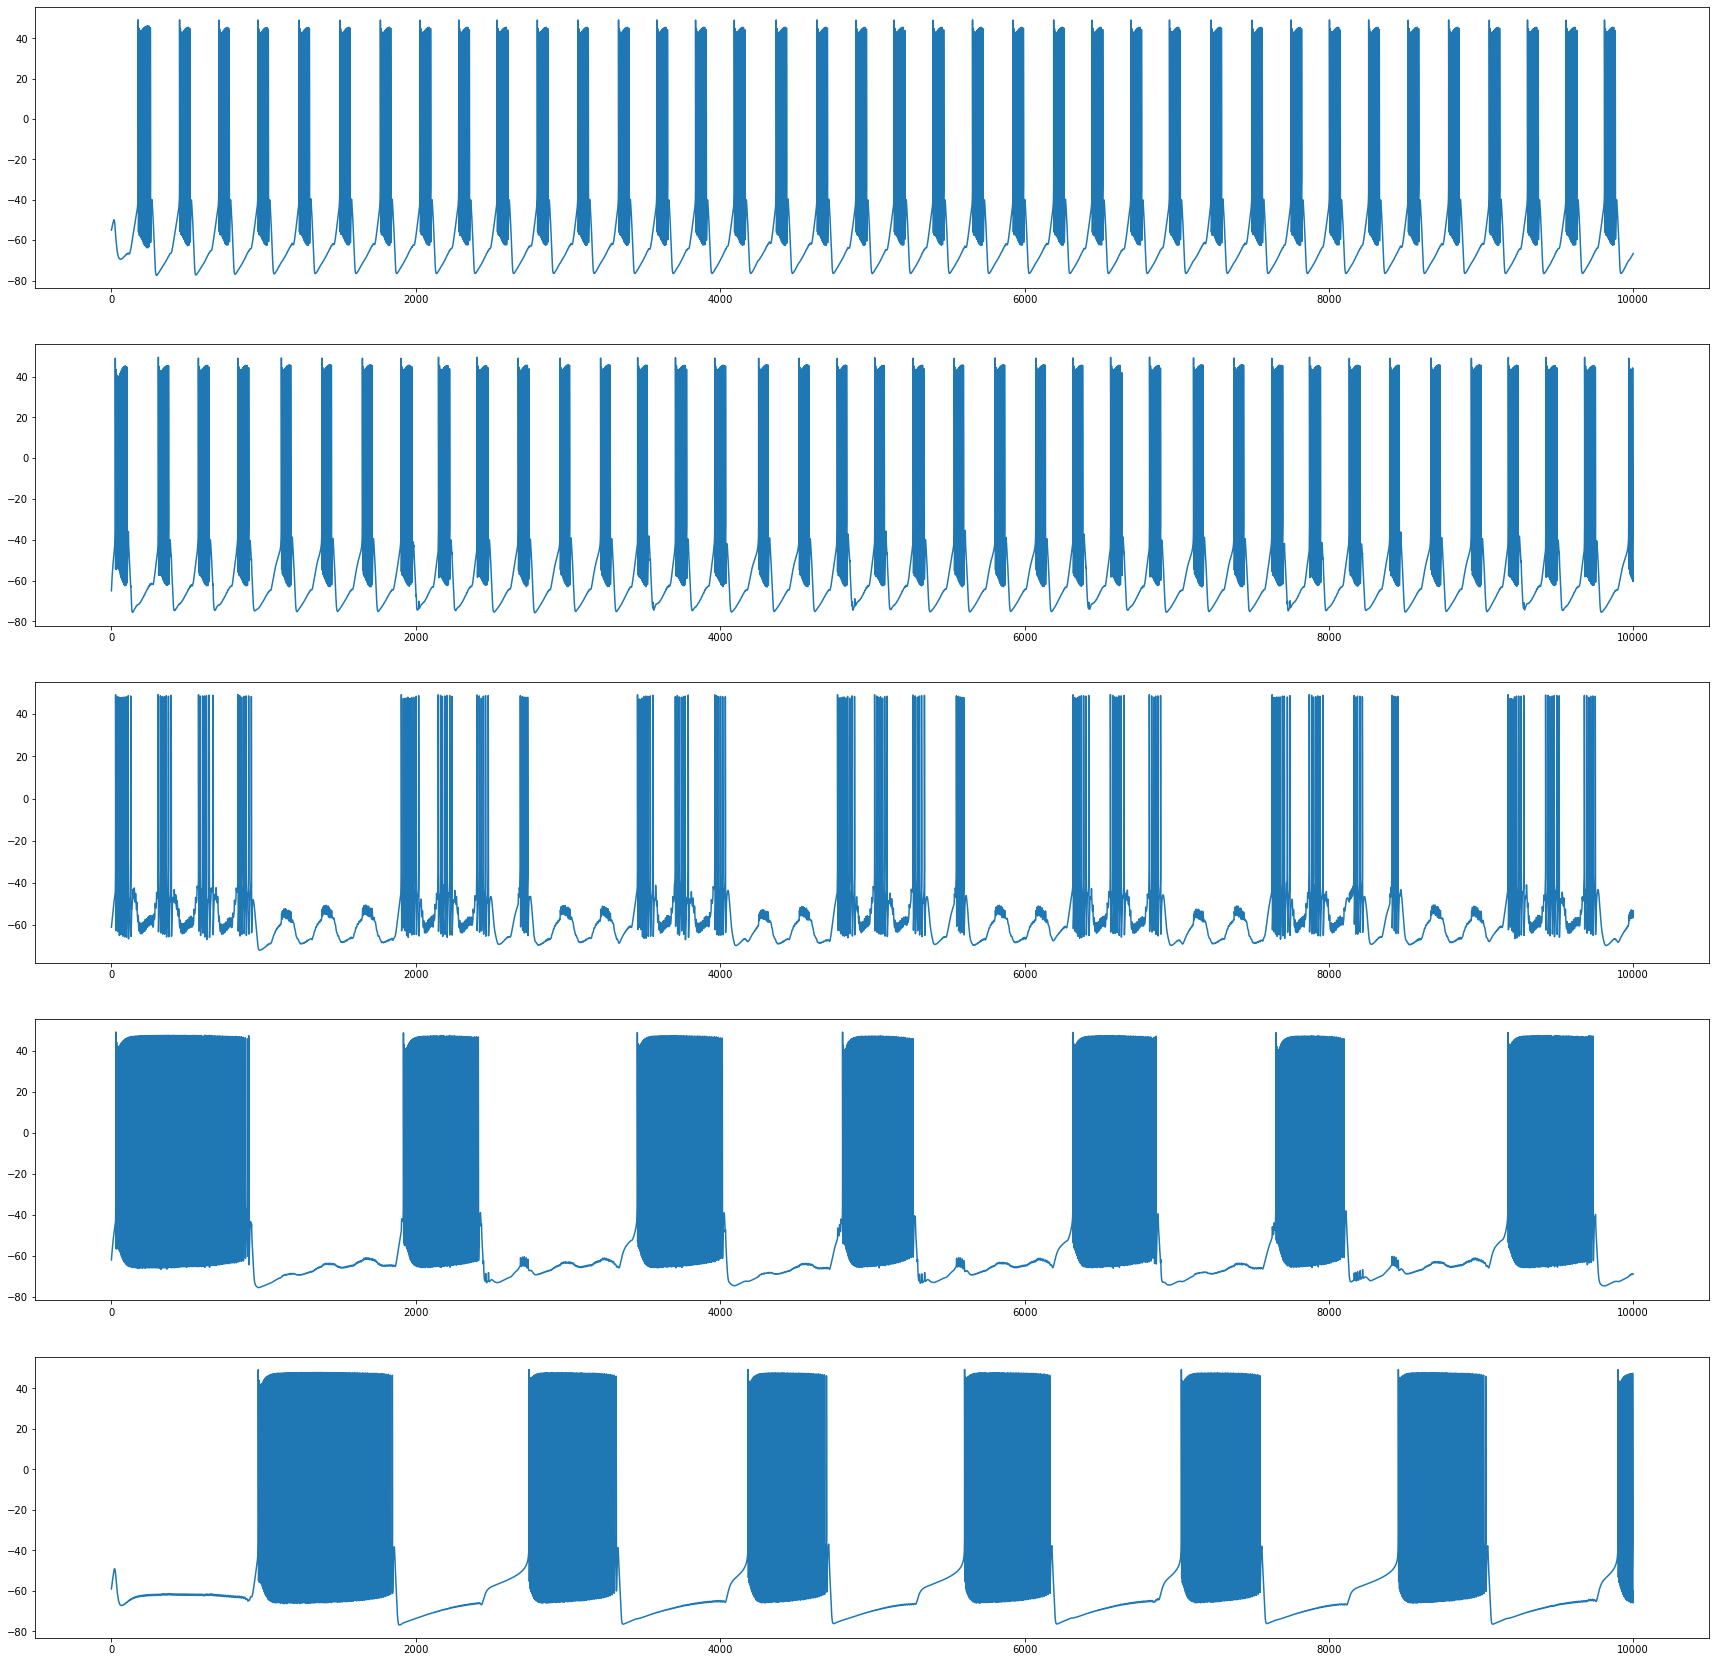

In [9]:
print(len(sol2.y[0]))
plt.figure(figsize=(30, 30))
plt.subplot(5, 1, 1)
plt.plot(sol2.t, sol2.y[0])
plt.subplot(5, 1, 2)
plt.plot(sol2.t, sol2.y[net1.cells[0].pos_dinamics])
plt.subplot(5, 1, 3)
plt.plot(sol2.t, sol2.y[net1.cells[0].pos_dinamics+net1.cells[1].pos_dinamics])
plt.subplot(5, 1, 4)
plt.plot(sol2.t, sol2.y[net1.cells[0].pos_dinamics+net1.cells[1].pos_dinamics+net1.cells[2].pos_dinamics])
plt.subplot(5, 1, 5)
plt.plot(sol2.t, sol2.y[net1.cells[0].pos_dinamics+net1.cells[1].pos_dinamics+net1.cells[2].pos_dinamics+net1.cells[3].pos_dinamics])
plt.show()

In [19]:
# Model parameters (global)
VNa = 50
VK = -80
VCa = 80
VH = -20
Vleak = -50
Vsyn = -75
taus = 10.
C = 1.
taumean=30.

# Model parameters (mean)
Iappvec = 0.*ones(5)

Iappvec = 0.*ones(5) + 0/2*(np.random.rand(5)-0.5)
kcvec = 0.94*ones(5)
KdCavec = 3.*ones(5)

gleakvec = 0.01*ones(5)

gNavec = [652.814,503.58,634.723,459.807,616.433]
gCaTvec = [0.992884,0.824788,1.04958,1.14911,0.971846]
gCaTvec_MOD = [2.38666,3.19092,2.3409,2.82957,3.52574]
gCaSvec = [3.51903,3.38981,3.36012,2.49984,2.50894]
gCaSvec_MOD = [8.52841,8.59527,9.24152,9.73135,8.79102]
gAvec = [51.5008,58.3269,40.3572,58.5102,51.8502]
gKdvec = [109.659,74.1655,74.7833,91.1938,111.87]
gKCavec = [63.0373,54.1351,65.7822,55.9324,70.2168]
gHvec = [0.107445,0.0929811,0.078182,0.083414,0.0887343]
tmKCavec = [3.93883,3.24514,5.55055,12.6351,16.6223]

gsyn12 = 0.07635083670743605
gsyn13 = 0.07988922275521991
gsyn21 = 0.07716951193265496
gsyn45 = 0.07762158408977728
gsyn53 = .08835472319081544
gsyn54 = 0.11712333284581126
gEl23 = 0.021083916923133217
gEl43 = 0.022874860313218278

In [20]:
cells=[]
for i in range(5):
    cells.append(neuron(NumbaList(
        [gCaTvec[i],gKdvec[i],gHvec[i],gNavec[i],gAvec[i],gCaSvec[i],gKCavec[i],C,gleakvec[i],KdCavec[i],kcvec[i]]
    )))
    cells[i].set_input(NumbaList([Iappvec[i],0,0,0,0,0,0,2.,0,0]))
    cells[i].set_rev(NumbaList([VNa,VCa,VK,VH,Vleak,VSyn]))
    cells[i].set_tau(tmKCavec[i],1.,10.)
    
net1=network(cells,[[0,gsyn21,0.,0.,0.],[gsyn12,0.,0.,0.,0.],[gsyn13,0.,0.,0.,gsyn53],[0.,0.,0.,0.,gsyn54],[0.,0.,0.,gsyn45,0.]],
         [[0.,0.,0.,0.,0.],[0.,0.,gEl23,0.,0.],[0.,gEl23,0.,gEl43,0.],[0.,0.,gEl43,0.,0.],[0.,0.,0.,0.,0.]])

X0=[*net1.cells[0].init_cond(-60+5),*net1.cells[1].init_cond(-60-5),*net1.cells[2].init_cond(-61),*net1.cells[3].init_cond(-60-2),*net1.cells[4].init_cond(-60+1)]
## Definition of simulation time.
Tfinal=10000.0
tspan=[0.0,Tfinal]
start = time.time()
sol=solve_ivp(net1.sys_equ,tspan , X0)
end = time.time()
print("Elapsed (with compilation) = %s" % (end - start))

num_Theta 8
num_Theta 8
num_Theta 8
num_Theta 8
num_Theta 8
num_Theta 8
num_Theta 9
num_Theta 9
num_Theta 10
num_Theta 10
num_Theta 12
num_Theta 9
num_Theta 10
num_Theta 8
num_Theta 9
Elapsed (with compilation) = 35.43418216705322


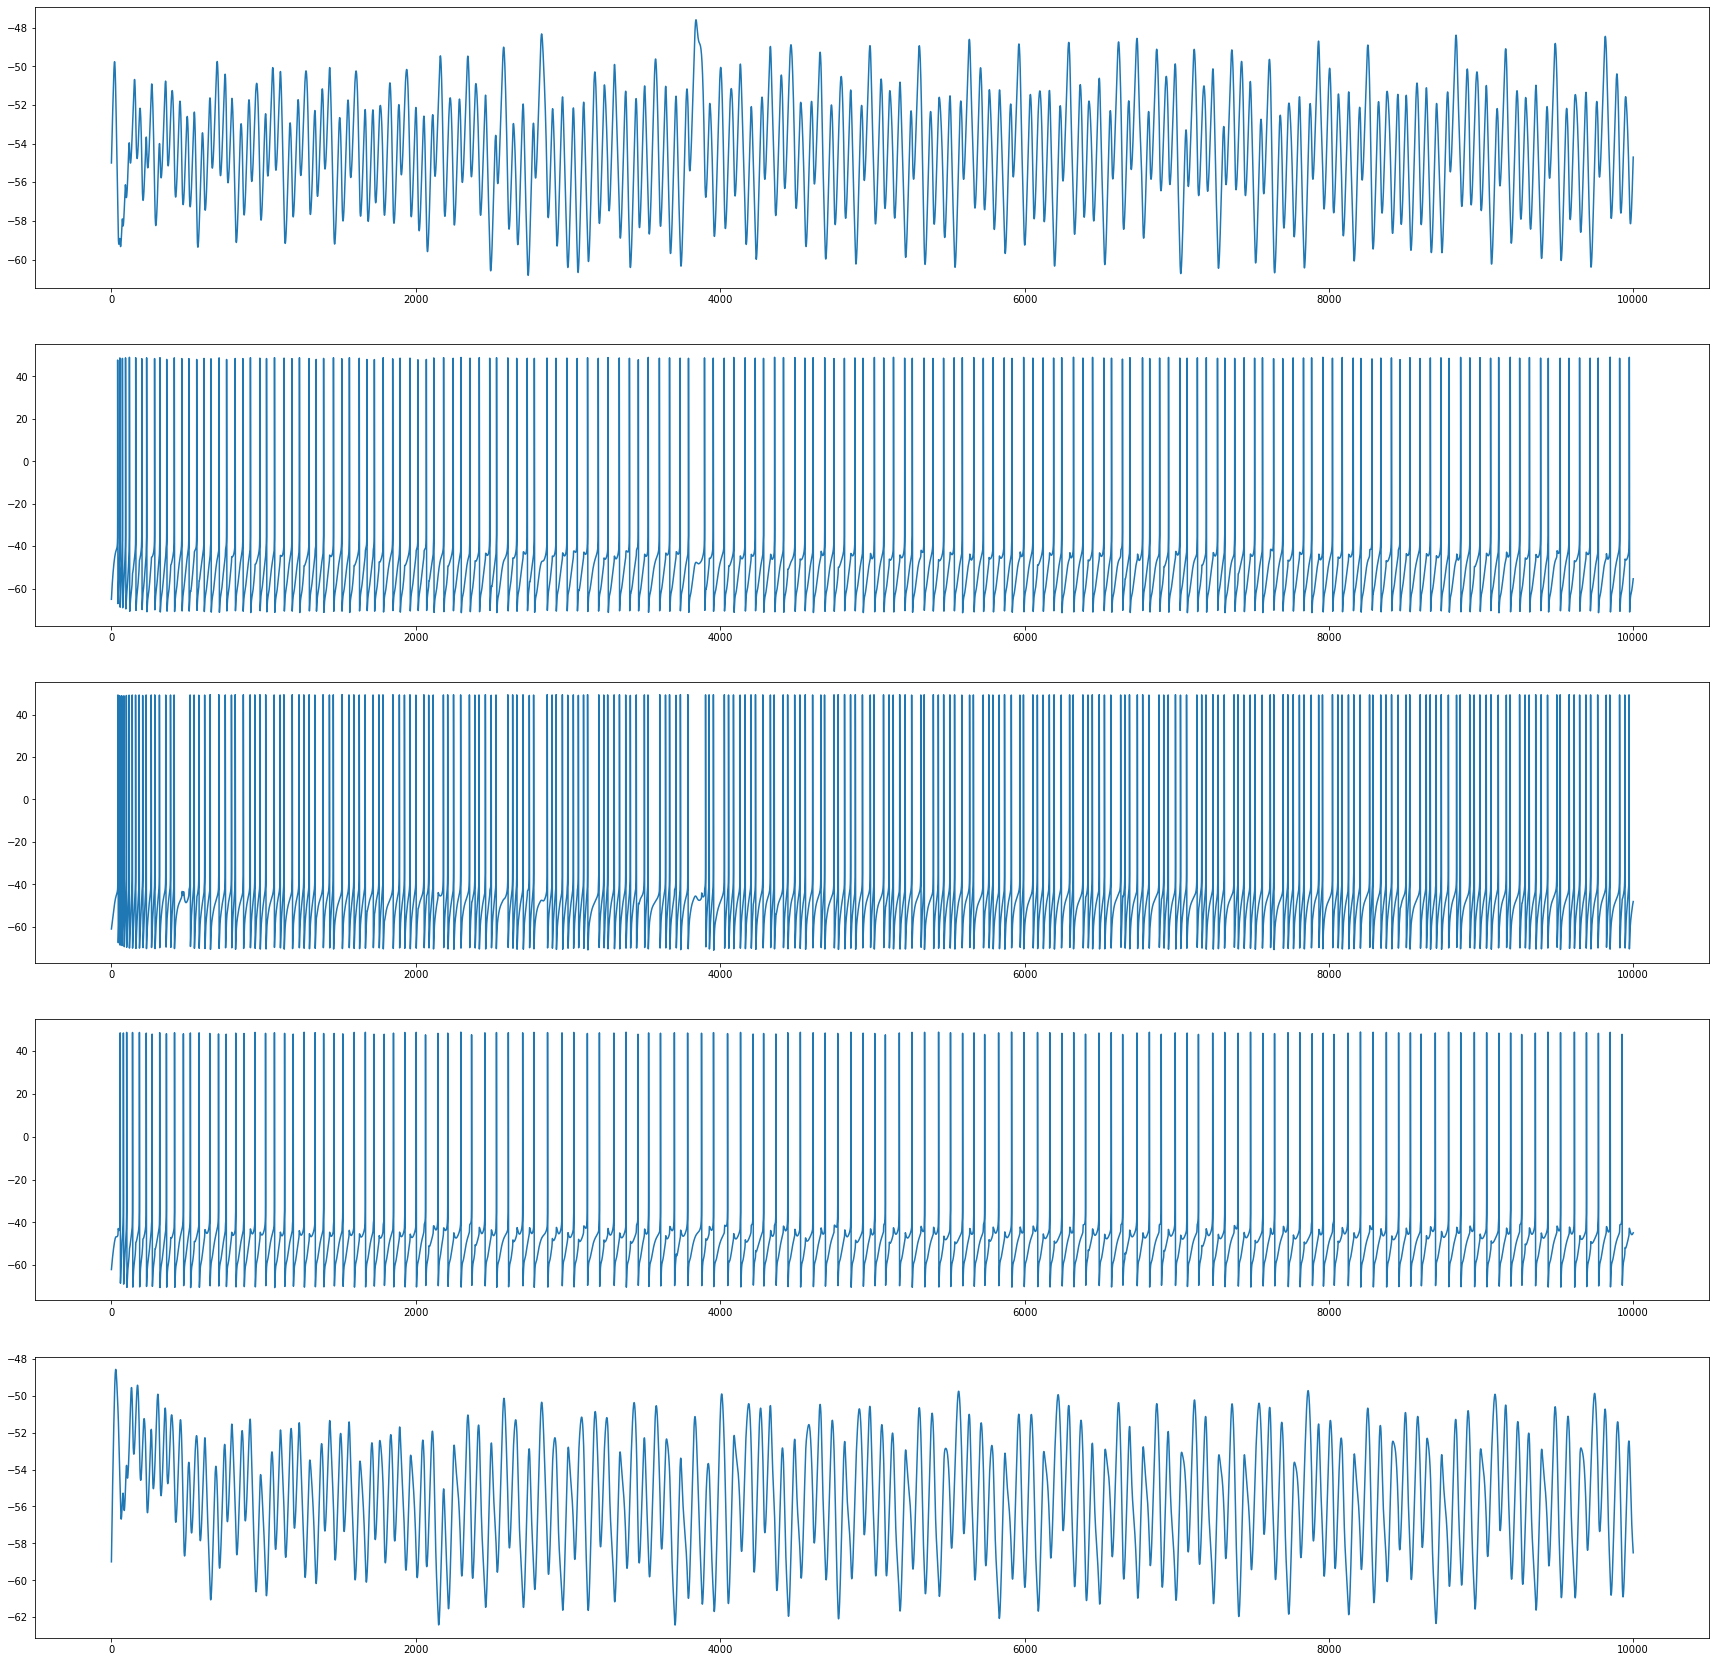

In [21]:
plt.figure(figsize=(30, 30))
plt.subplot(5, 1, 1)
plt.plot(sol.t, sol.y[0])
plt.subplot(5, 1, 2)
plt.plot(sol.t, sol.y[net1.cells[0].pos_dinamics])
plt.subplot(5, 1, 3)
plt.plot(sol.t, sol.y[net1.cells[0].pos_dinamics+net1.cells[1].pos_dinamics])
plt.subplot(5, 1, 4)
plt.plot(sol.t, sol.y[net1.cells[0].pos_dinamics+net1.cells[1].pos_dinamics+net1.cells[2].pos_dinamics])
plt.subplot(5, 1, 5)
plt.plot(sol.t, sol.y[net1.cells[0].pos_dinamics+net1.cells[1].pos_dinamics+net1.cells[2].pos_dinamics+net1.cells[3].pos_dinamics])
plt.show()

In [22]:
import copy
def random_MOD(MOD):
  #MOD = rand(5)
    gCaTvec_now = gCaTvec.copy()
    gCaSvec_now = gCaSvec.copy()
    for i in range(len(MOD)):
        if (MOD[i] < 0.5):
            MOD[i] = 0.
            gCaTvec_now[i] = copy.copy(gCaTvec[i])
            gCaSvec_now[i] = copy.copy(gCaSvec[i])
        else:
            MOD[i] = 1.
            gCaTvec_now[i] = copy.copy(gCaTvec_MOD[i])
            gCaSvec_now[i] = copy.copy(gCaSvec_MOD[i])
    
    cells=[]
    for i in range(5):
        cells.append(neuron(NumbaList(
            [gCaTvec_now[i],gKdvec[i],gHvec[i],gNavec[i],gAvec[i],gCaSvec_now[i],gKCavec[i],C,gleakvec[i],KdCavec[i],kcvec[i]]
        )))
        cells[i].set_input(NumbaList([Iappvec[i],0,0,0,0,0,0,2,0,0]))
        cells[i].set_rev(NumbaList([VNa,VCa,VK,VH,Vleak,VSyn]))
        cells[i].set_tau(tmKCavec[i],1.,10.)
    net1=network(cells,[[0,gsyn21,0.,0.,0.],[gsyn12,0.,0.,0.,0.],[gsyn13,0.,0.,0.,gsyn53],[0.,0.,0.,0.,gsyn54],[0.,0.,0.,gsyn45,0.]],
         [[0.,0.,0.,0.,0.],[0.,0.,gEl23,0.,0.],[0.,gEl23,0.,gEl43,0.],[0.,0.,gEl43,0.,0.],[0.,0.,0.,0.,0.]])
    
    return net1
   

In [23]:
net1=random_MOD([1.,0.,0.,0.,1.])
X0=[*net1.cells[0].init_cond(-60+5),*net1.cells[1].init_cond(-60-5),*net1.cells[2].init_cond(-61),*net1.cells[3].init_cond(-60-2),*net1.cells[4].init_cond(-60+1)]
## Definition of simulation time.
Tfinal=10000.0
tspan=[0.0,Tfinal]
start = time.time()
sol=solve_ivp(net1.sys_equ,tspan , X0)
end = time.time()
print("Elapsed (with compilation) = %s" % (end - start))

num_Theta 8
num_Theta 8
num_Theta 8
num_Theta 8
num_Theta 8
num_Theta 8
num_Theta 9
num_Theta 9
num_Theta 10
num_Theta 10
num_Theta 12
num_Theta 9
num_Theta 10
num_Theta 8
num_Theta 9
Elapsed (with compilation) = 70.26996922492981


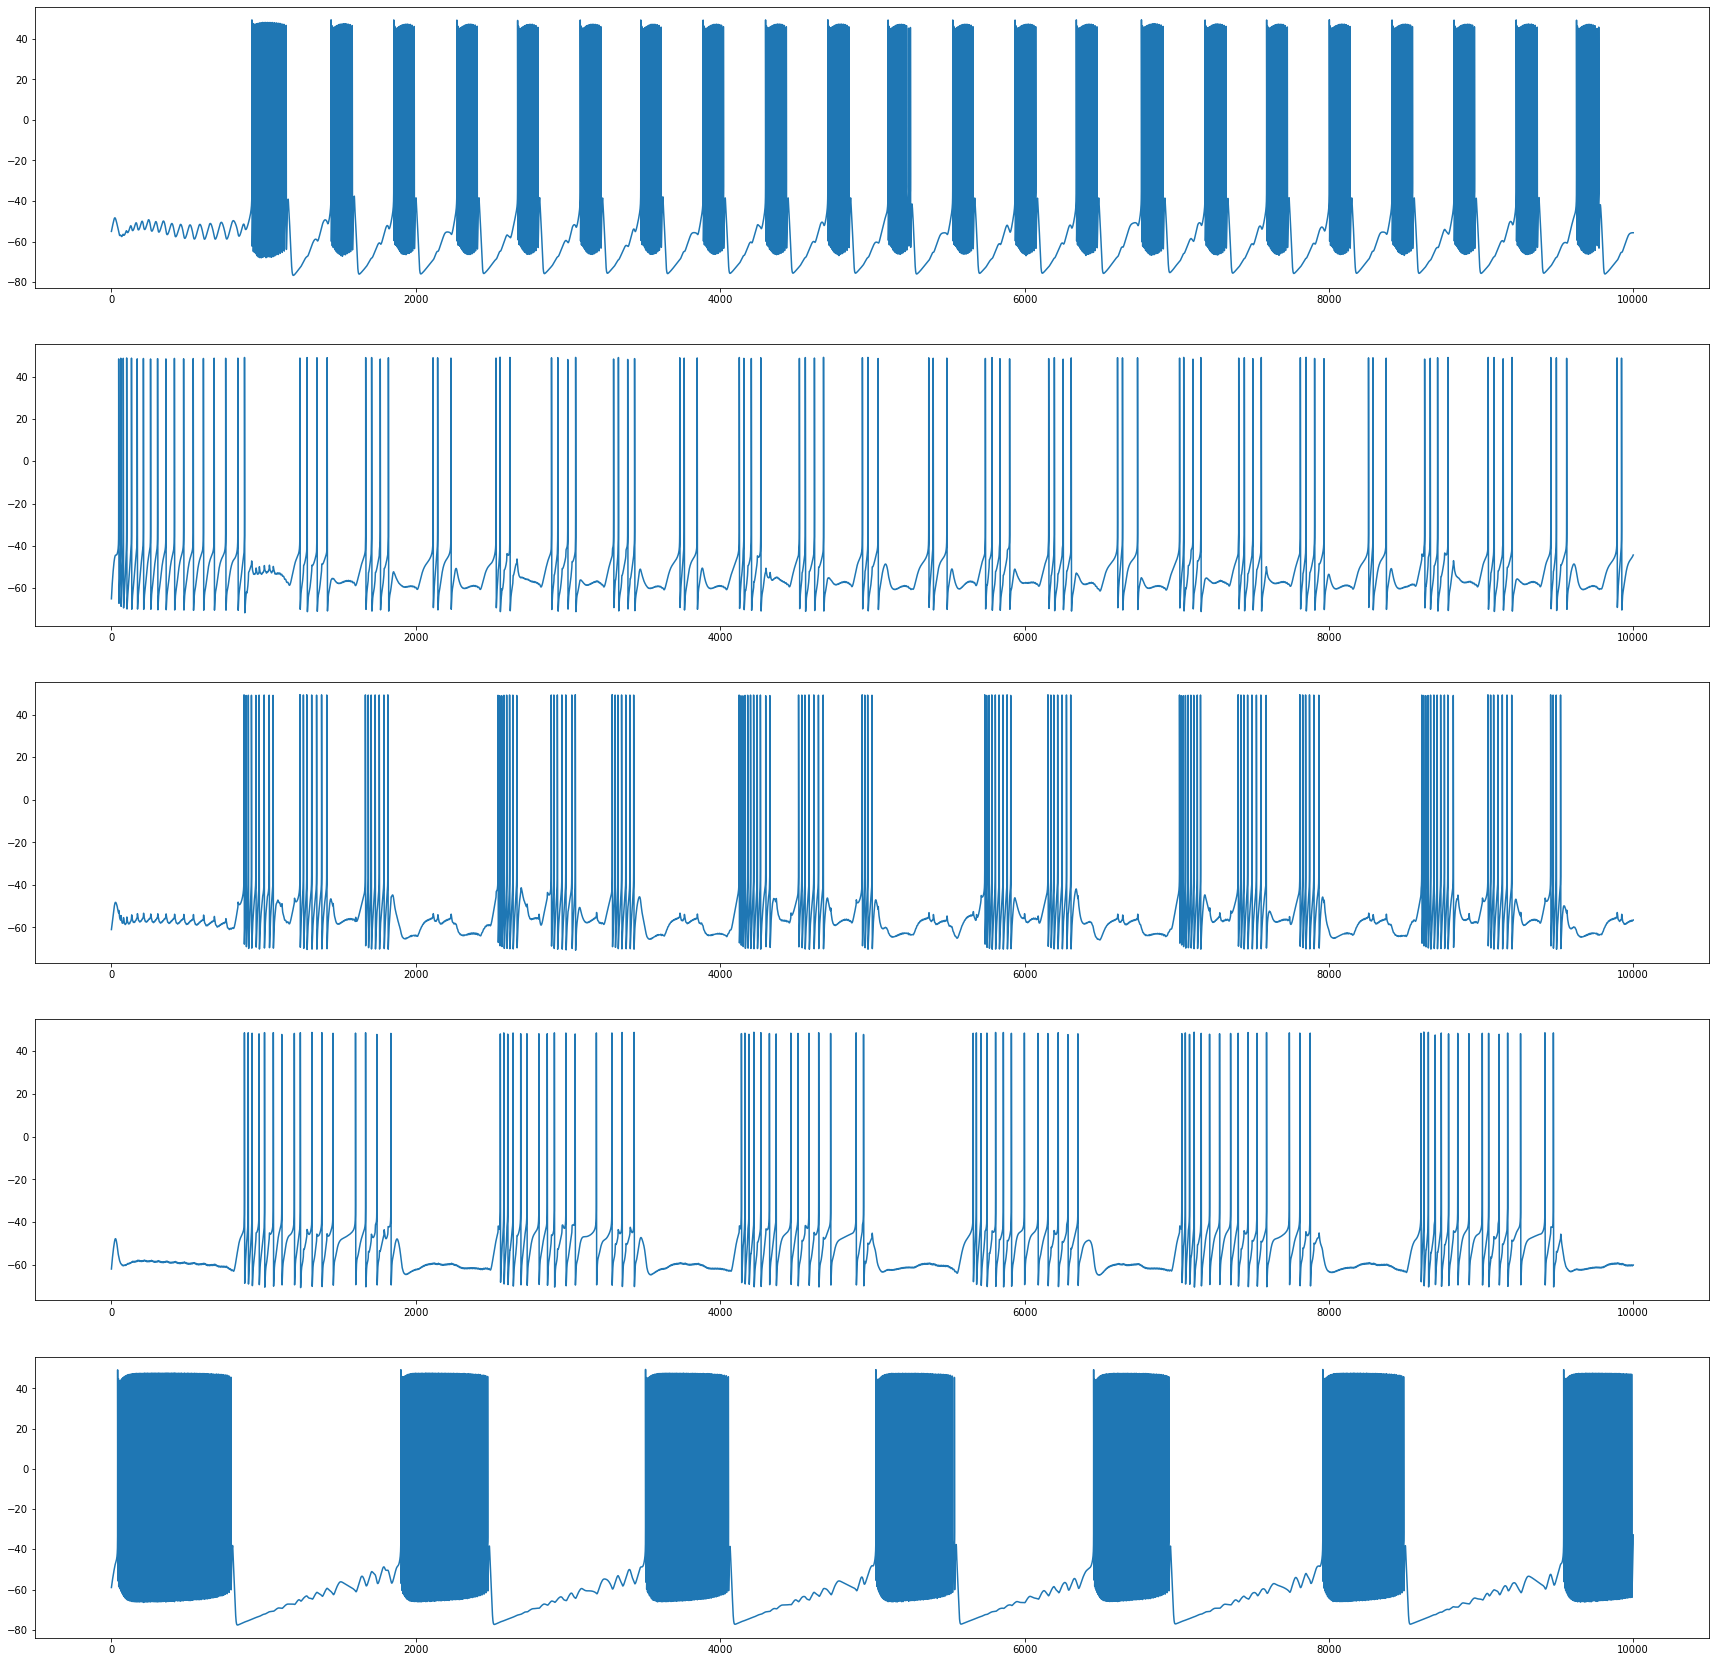

In [24]:
plt.figure(figsize=(30, 30))
plt.subplot(5, 1, 1)
plt.plot(sol.t, sol.y[0])
plt.subplot(5, 1, 2)
plt.plot(sol.t, sol.y[net1.cells[0].pos_dinamics])
plt.subplot(5, 1, 3)
plt.plot(sol.t, sol.y[net1.cells[0].pos_dinamics+net1.cells[1].pos_dinamics])
plt.subplot(5, 1, 4)
plt.plot(sol.t, sol.y[net1.cells[0].pos_dinamics+net1.cells[1].pos_dinamics+net1.cells[2].pos_dinamics])
plt.subplot(5, 1, 5)
plt.plot(sol.t, sol.y[net1.cells[0].pos_dinamics+net1.cells[1].pos_dinamics+net1.cells[2].pos_dinamics+net1.cells[3].pos_dinamics])
plt.show()

In [25]:
net1=random_MOD([0.,0.,0.,1.,1.])
X0=[*net1.cells[0].init_cond(-60+5),*net1.cells[1].init_cond(-60-5),*net1.cells[2].init_cond(-61),*net1.cells[3].init_cond(-60-2),*net1.cells[4].init_cond(-60+1)]
## Definition of simulation time.
Tfinal=10000.0
tspan=[0.0,Tfinal]
start = time.time()
sol2=solve_ivp(net1.sys_equ,tspan , X0)
end = time.time()
print("Elapsed (with compilation) = %s" % (end - start))

num_Theta 8
num_Theta 8
num_Theta 8
num_Theta 8
num_Theta 8
num_Theta 8
num_Theta 9
num_Theta 9
num_Theta 10
num_Theta 10
num_Theta 12
num_Theta 9
num_Theta 10
num_Theta 8
num_Theta 9
Elapsed (with compilation) = 68.62552762031555


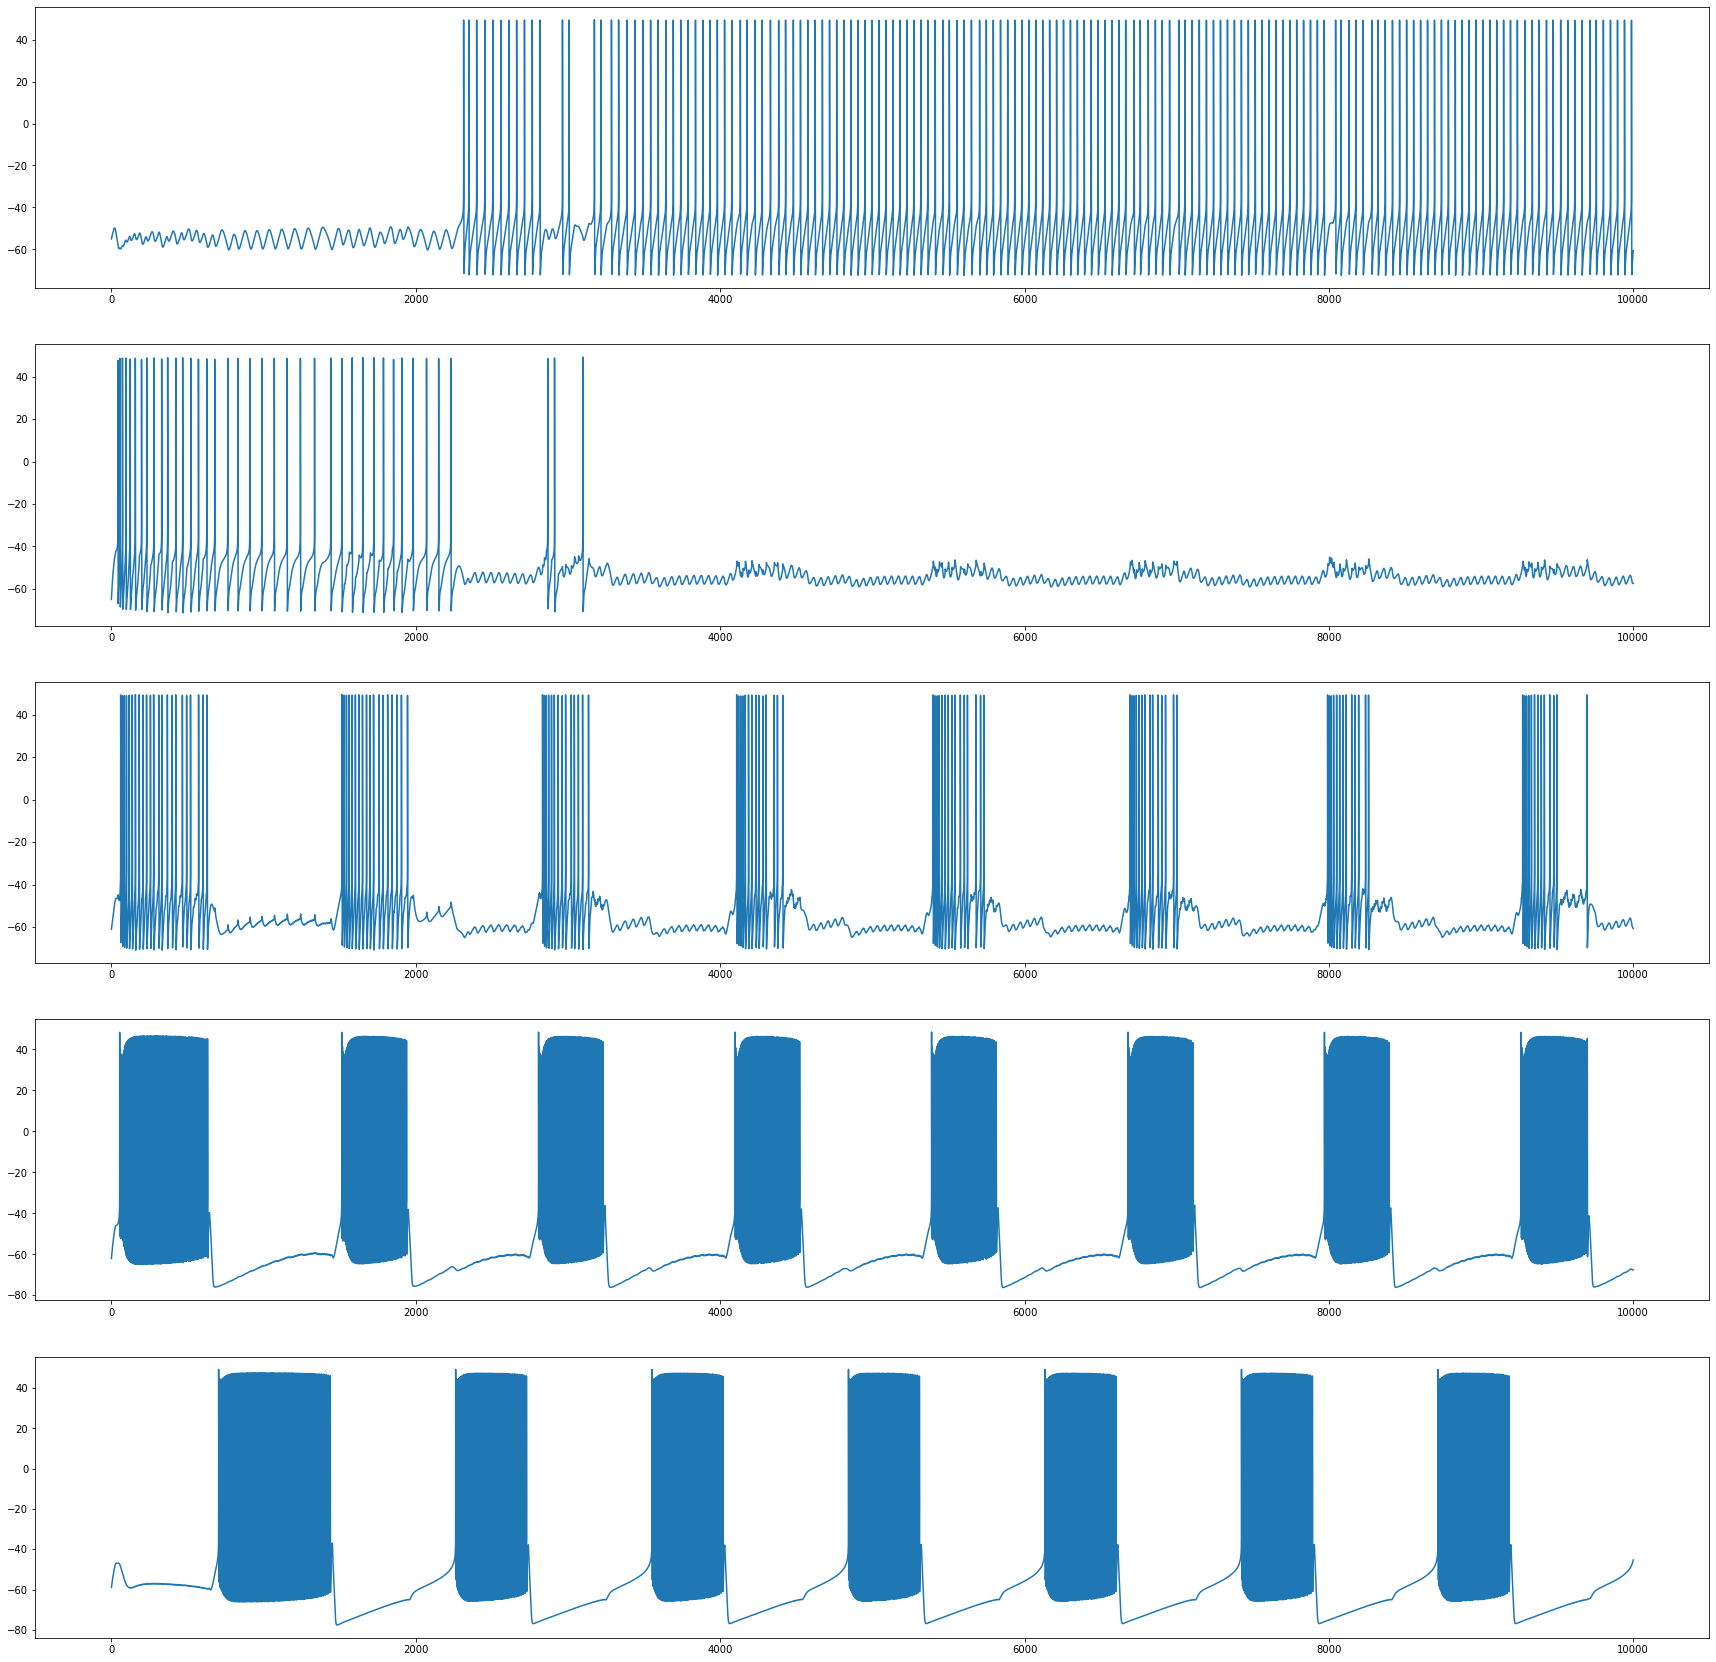

In [26]:
plt.figure(figsize=(30, 30))
plt.subplot(5, 1, 1)
plt.plot(sol2.t, sol2.y[0])
plt.subplot(5, 1, 2)
plt.plot(sol2.t, sol2.y[net1.cells[0].pos_dinamics])
plt.subplot(5, 1, 3)
plt.plot(sol2.t, sol2.y[net1.cells[0].pos_dinamics+net1.cells[1].pos_dinamics])
plt.subplot(5, 1, 4)
plt.plot(sol2.t, sol2.y[net1.cells[0].pos_dinamics+net1.cells[1].pos_dinamics+net1.cells[2].pos_dinamics])
plt.subplot(5, 1, 5)
plt.plot(sol2.t, sol2.y[net1.cells[0].pos_dinamics+net1.cells[1].pos_dinamics+net1.cells[2].pos_dinamics+net1.cells[3].pos_dinamics])
plt.show()

In [27]:
net1=random_MOD([1.,1.,0.,0.,0.])
X0=[*net1.cells[0].init_cond(-60+5),*net1.cells[1].init_cond(-60-5),*net1.cells[2].init_cond(-61),*net1.cells[3].init_cond(-60-2),*net1.cells[4].init_cond(-60+1)]
## Definition of simulation time.
Tfinal=10000.0
tspan=[0.0,Tfinal]
start = time.time()
sol3=solve_ivp(net1.sys_equ,tspan , X0)
end = time.time()
print("Elapsed (with compilation) = %s" % (end - start))

num_Theta 8
num_Theta 8
num_Theta 8
num_Theta 8
num_Theta 8
num_Theta 8
num_Theta 9
num_Theta 9
num_Theta 10
num_Theta 10
num_Theta 12
num_Theta 9
num_Theta 10
num_Theta 8
num_Theta 9
Elapsed (with compilation) = 69.99920439720154


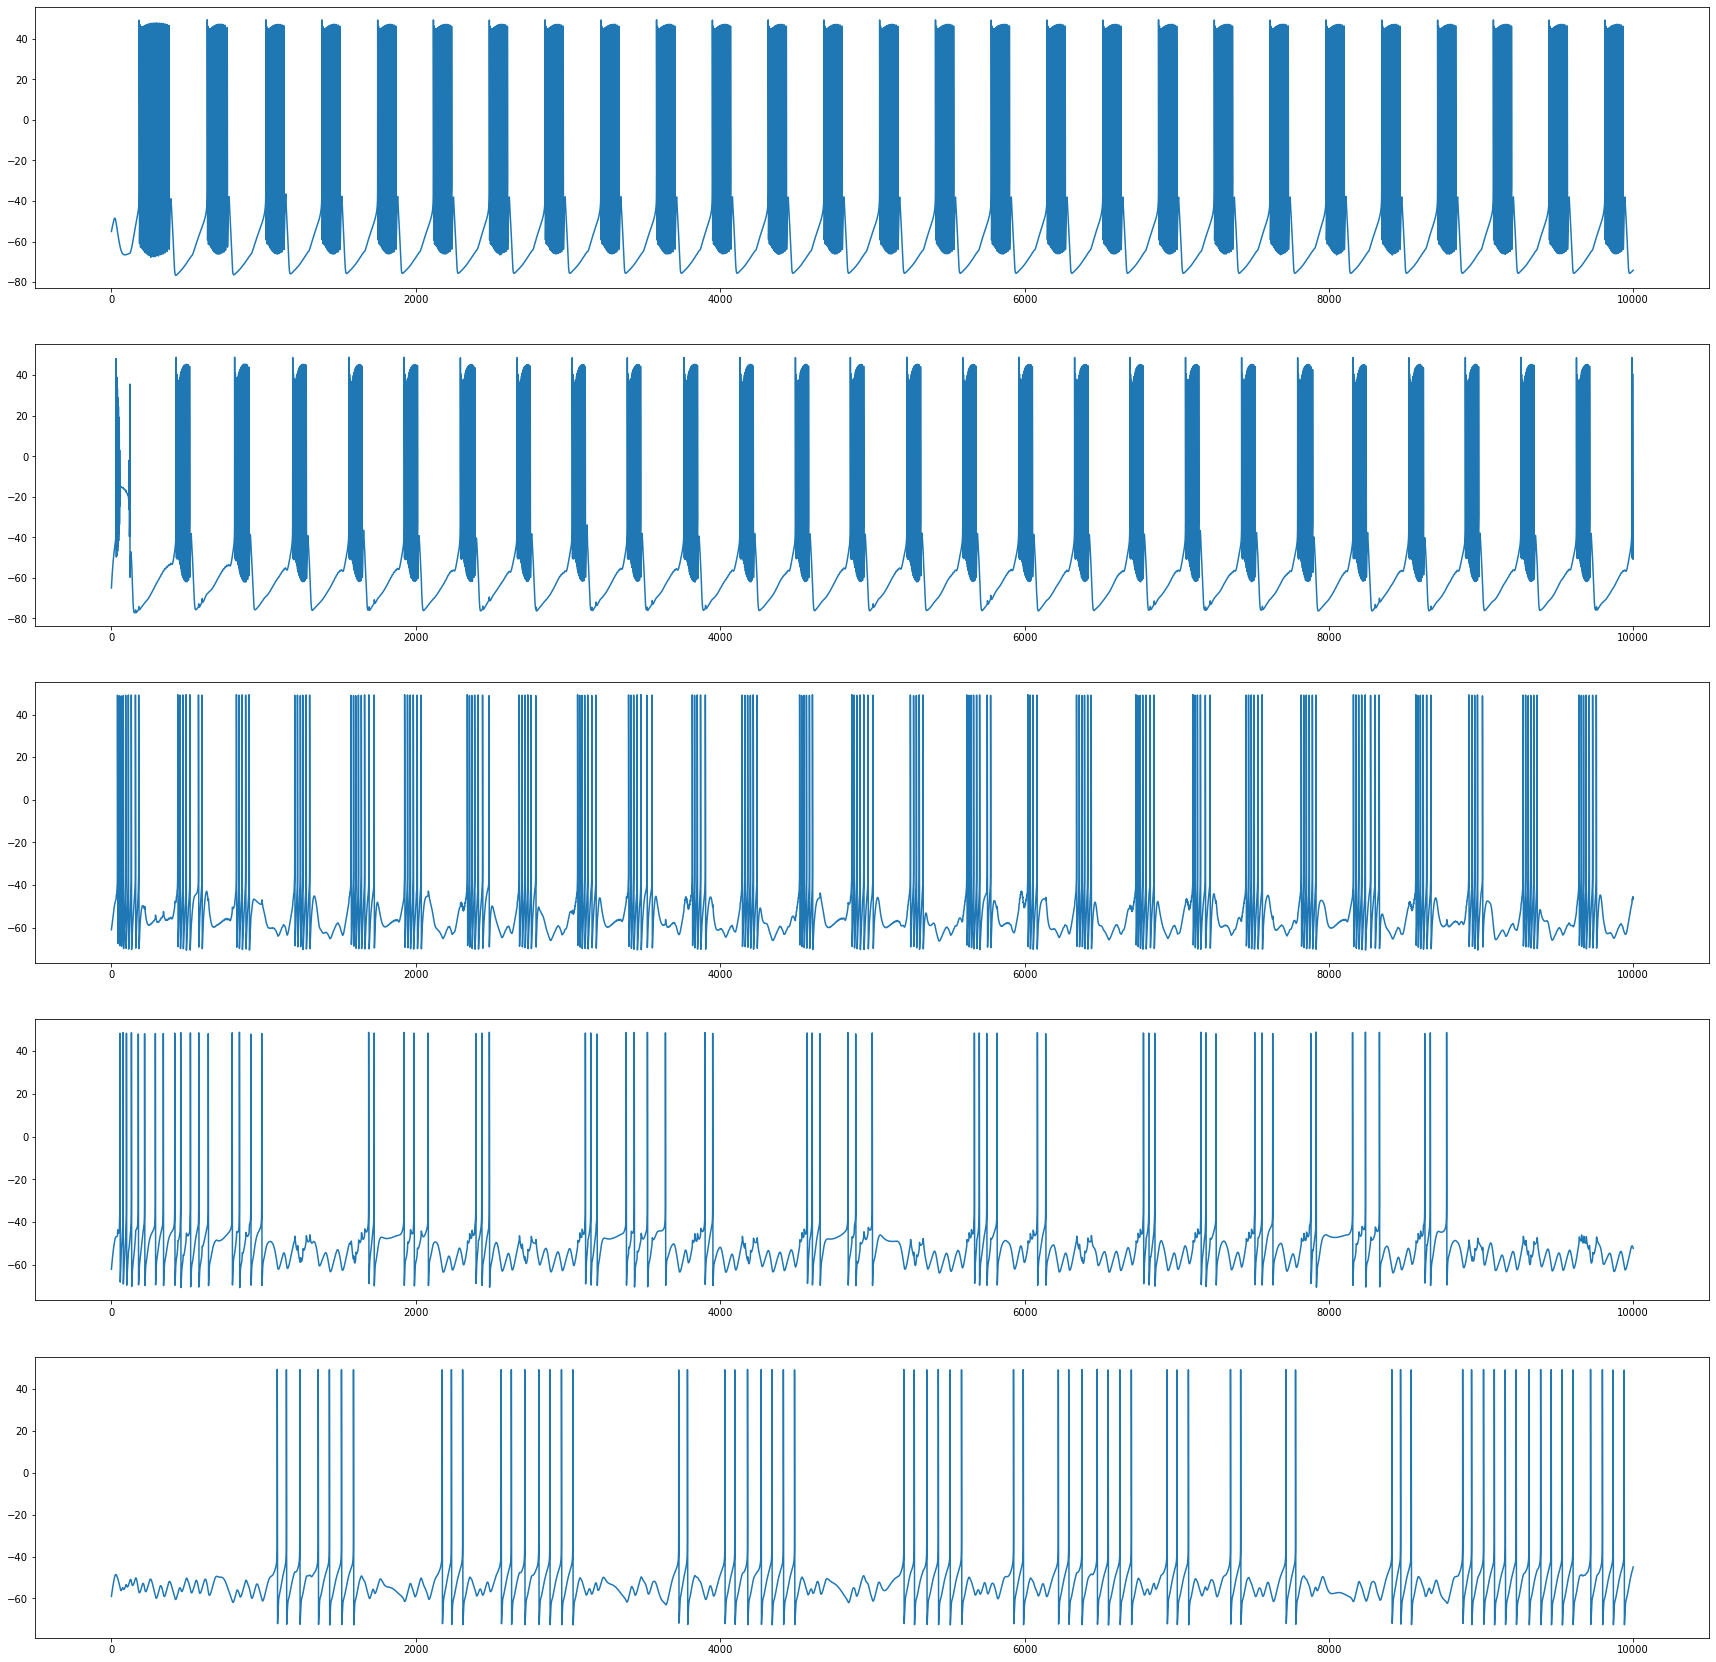

In [28]:
plt.figure(figsize=(30, 30))
plt.subplot(5, 1, 1)
plt.plot(sol3.t, sol3.y[0])
plt.subplot(5, 1, 2)
plt.plot(sol3.t, sol3.y[net1.cells[0].pos_dinamics])
plt.subplot(5, 1, 3)
plt.plot(sol3.t, sol3.y[net1.cells[0].pos_dinamics+net1.cells[1].pos_dinamics])
plt.subplot(5, 1, 4)
plt.plot(sol3.t, sol3.y[net1.cells[0].pos_dinamics+net1.cells[1].pos_dinamics+net1.cells[2].pos_dinamics])
plt.subplot(5, 1, 5)
plt.plot(sol3.t, sol3.y[net1.cells[0].pos_dinamics+net1.cells[1].pos_dinamics+net1.cells[2].pos_dinamics+net1.cells[3].pos_dinamics])
plt.show()

In [29]:
net1=random_MOD([0.,1.,1.,1.,0.])
X0=[*net1.cells[0].init_cond(-60+5),*net1.cells[1].init_cond(-60-5),*net1.cells[2].init_cond(-61),*net1.cells[3].init_cond(-60-2),*net1.cells[4].init_cond(-60+1)]
## Definition of simulation time.
Tfinal=10000.0
tspan=[0.0,Tfinal]
start = time.time()
sol4=solve_ivp(net1.sys_equ,tspan , X0)
end = time.time()
print("Elapsed (with compilation) = %s" % (end - start))

num_Theta 8
num_Theta 8
num_Theta 8
num_Theta 8
num_Theta 8
num_Theta 8
num_Theta 9
num_Theta 9
num_Theta 10
num_Theta 10
num_Theta 12
num_Theta 9
num_Theta 10
num_Theta 8
num_Theta 9
Elapsed (with compilation) = 73.96408486366272


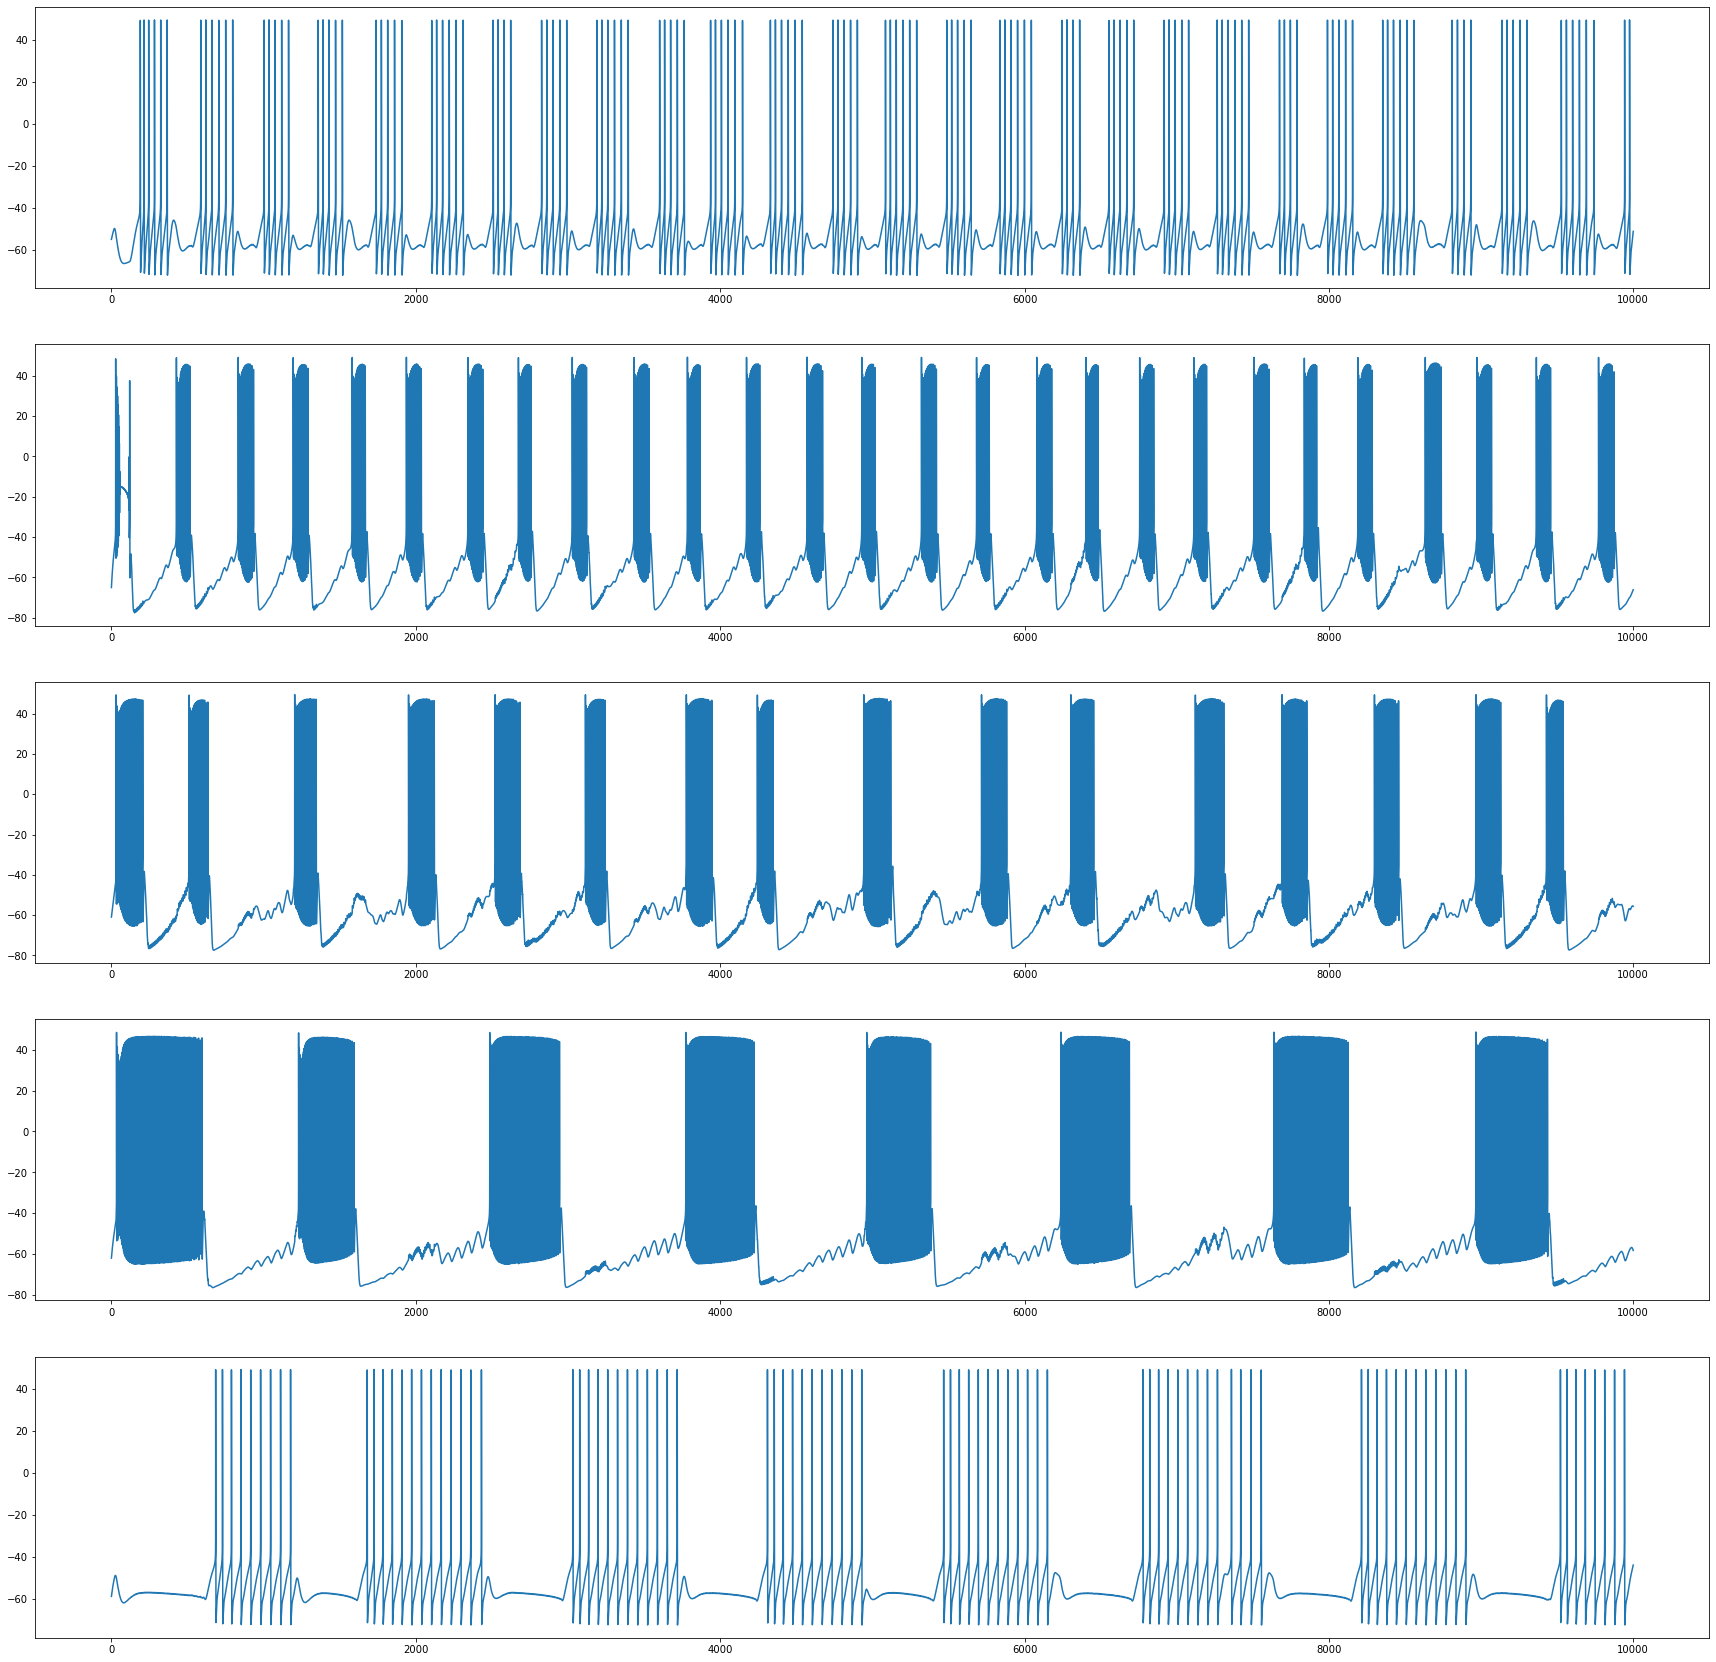

In [30]:
plt.figure(figsize=(30, 30))
plt.subplot(5, 1, 1)
plt.plot(sol4.t, sol4.y[0])
plt.subplot(5, 1, 2)
plt.plot(sol4.t, sol4.y[net1.cells[0].pos_dinamics])
plt.subplot(5, 1, 3)
plt.plot(sol4.t, sol4.y[net1.cells[0].pos_dinamics+net1.cells[1].pos_dinamics])
plt.subplot(5, 1, 4)
plt.plot(sol4.t, sol4.y[net1.cells[0].pos_dinamics+net1.cells[1].pos_dinamics+net1.cells[2].pos_dinamics])
plt.subplot(5, 1, 5)
plt.plot(sol4.t, sol4.y[net1.cells[0].pos_dinamics+net1.cells[1].pos_dinamics+net1.cells[2].pos_dinamics+net1.cells[3].pos_dinamics])
plt.show()

In [32]:
net1=random_MOD([0.,1.,1.,1.,0.])
#Hyperparameters
gamma=10.
alpha=0.005
variable_mask1=np.array([1.,1.,1.,1.,1.,1.,1.,1.,1.])
variable_mask2=np.array([1.,1.,1.,1.,1.,1.,1.,1.,1.,1.])
variable_mask3=np.array([1.,1.,1.,1.,1.,1.,1.,1.,1.,1.,1.,1.])
net1.cells[0].set_hyp(gamma,alpha,variable_mask1)
net1.cells[1].set_hyp(gamma,alpha,variable_mask2)
net1.cells[2].set_hyp(gamma,alpha,variable_mask3)
net1.cells[3].set_hyp(gamma,alpha,variable_mask2)
net1.cells[4].set_hyp(gamma,alpha,variable_mask1)

num_Theta 8
num_Theta 8
num_Theta 8
num_Theta 8
num_Theta 8
num_Theta 8
num_Theta 9
num_Theta 9
num_Theta 10
num_Theta 10
num_Theta 12
num_Theta 9
num_Theta 10
num_Theta 8
num_Theta 9


In [33]:
X0=[*net1.cells[0].init_cond_OB(-60+5),*net1.cells[1].init_cond_OB(-60-5),*net1.cells[2].init_cond_OB(-61),*net1.cells[3].init_cond_OB(-60-2),*net1.cells[4].init_cond_OB(-60+1)]
## Definition of simulation time.
Tfinal=10000.0
tspan=[0.0,Tfinal]
start = time.time()
sol5=solve_ivp(net1.ob_equ,tspan , X0)
end = time.time()
print("Elapsed (with compilation) = %s" % (end - start))

[ 7.2331905   5.797491   27.21922058 73.93985296 73.11483192  6.58163517
 61.33162083 89.29753988 50.43543228]
[-78.82606104]
[93.95636239 95.81154563 59.63173889  4.81018673 37.90461791 83.26149876
 86.57183654 53.86111741 83.16230474 59.45697381]
[-83.25865622]
[64.52125362 45.25221355 29.39123547  9.34160645 54.46158802 34.79639009
 19.67633097 30.6637193  23.56016911 21.66163928 91.8275275  43.75131276]
[-61.31214973]
[63.9661157  64.66117802 85.86234421 15.86074843 19.44482597 28.72199498
 99.41398225  1.41728004 46.62457953 48.4942543 ]
[-34.55300135]
[74.09264529 61.33863476 51.46342241 75.29903566 66.85476258 53.196361
 32.37800729 74.8533802  32.69841623]
[-59.27912867]
Elapsed (with compilation) = 189.26159644126892


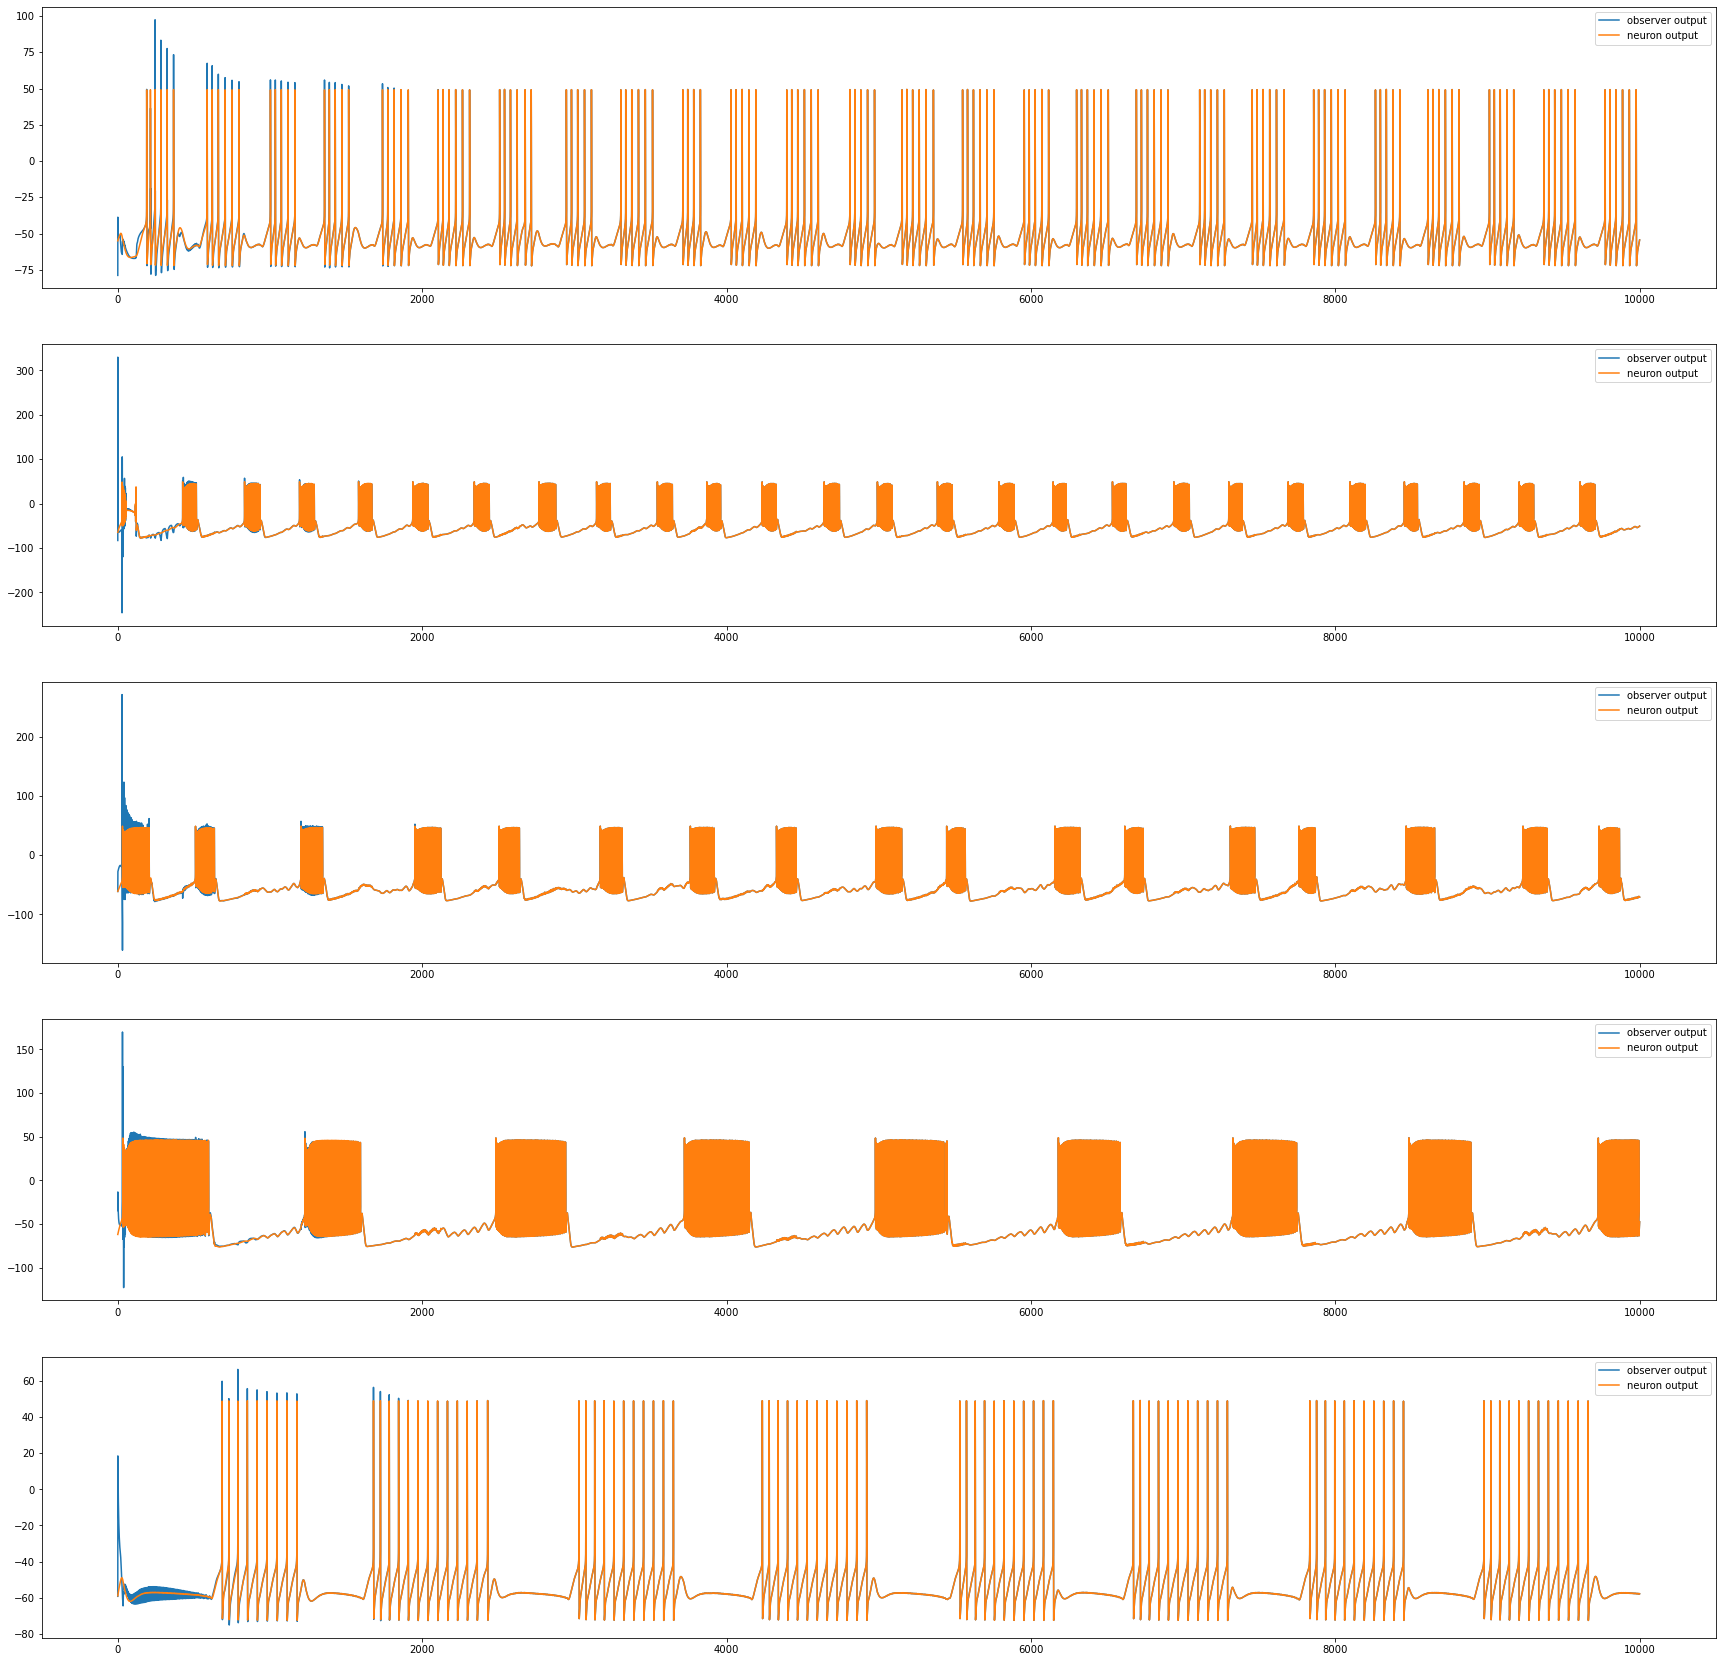

In [36]:
plt.figure(figsize=(30, 30))
plt.subplot(5, 1, 1)
plt.plot(sol5.t, sol5.y[0], label='observer output')
plt.plot(sol5.t, sol5.y[net1.cells[0].pos_p],label= 'neuron output')
plt.legend()
plt.subplot(5, 1, 2)
plt.plot(sol5.t, sol5.y[net1.cells[0].pos_u_sys] ,label='observer output')
plt.plot(sol5.t, sol5.y[net1.cells[0].pos_u_sys+net1.cells[1].pos_p],label= 'neuron output')
plt.legend()
plt.subplot(5, 1, 3)
plt.plot(sol5.t, sol5.y[net1.cells[0].pos_u_sys+net1.cells[1].pos_u_sys],label='observer output')
plt.plot(sol5.t, sol5.y[net1.cells[0].pos_u_sys+net1.cells[1].pos_u_sys+net1.cells[2].pos_p],label= 'neuron output')
plt.legend()
plt.subplot(5, 1, 4)
plt.plot(sol5.t, sol5.y[net1.cells[0].pos_u_sys+net1.cells[1].pos_u_sys+net1.cells[2].pos_u_sys],label='observer output')
plt.plot(sol5.t, sol5.y[net1.cells[0].pos_u_sys+net1.cells[1].pos_u_sys+net1.cells[2].pos_u_sys+net1.cells[3].pos_p],label= 'neuron output')
plt.legend()
plt.subplot(5, 1, 5)
plt.plot(sol5.t, sol5.y[net1.cells[0].pos_u_sys+net1.cells[1].pos_u_sys+net1.cells[2].pos_u_sys+net1.cells[3].pos_u_sys],label='observer output')
plt.plot(sol5.t, sol5.y[net1.cells[0].pos_u_sys+net1.cells[1].pos_u_sys+net1.cells[2].pos_u_sys+net1.cells[3].pos_u_sys+net1.cells[4].pos_p],label= 'neuron output')
plt.legend()
plt.show()